# CLASSICAL APPROACH

NOTE:

This notebook encompasses code from different notebooks. Each stage loads the file saved by the previous stage.

## Full Setup

In [ ]:
!pip -q install pymupdf pandas
!pip uninstall -y nltk
!pip install nltk==3.8.1
!pip install bertopic

import re, unicodedata
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import json
import os
import ast
import nltk
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math
import umap
import hdbscan
from collections import defaultdict, Counter
from google.colab import files
from IPython.display import display
from pathlib import Path
from openai import OpenAI


nltk_data_path = "/content/nltk_data"
os.makedirs(nltk_data_path, exist_ok=True)
nltk.download("punkt", download_dir=nltk_data_path)
nltk.download("stopwords", download_dir=nltk_data_path)
nltk.data.path.append(nltk_data_path)

from nltk import FreqDist, pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from sentence_transformers import SentenceTransformer, models
from sklearn.feature_extraction.text import CountVectorizer

Found existing installation: nltk 3.9.1
Uninstalling nltk-3.9.1:
  Successfully uninstalled nltk-3.9.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textblob 0.19.0 requires nltk>=3.9, but you have nltk 3.8.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 3.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Column guide for final dataframe (Stage 4)


- `bank`, `year`, `quarter`, `tag`, `file` — provenance  
- `question_speaker`, `analyst_firm`, `answer_speaker` — speakers  
- `extracted_question`, `extracted_answer` — atomic pair after LLM split  
- `answer_score` — answer directness (0.0–1.0)  
- `orientation`, `theme` — Stage 2 labels  
- `topic_q`, `topic_a`, `theme_q`, `theme_a` — Stage 3 topics and mapped themes  
- `question_emotion`, `answer_emotion`, `*_emotion_score`, `*_emotion_dist`, `*_sentiment` — Stage 4 tone features


# STAGE 1: Initial processing

At this stage we are processing the PDF files and extracting Q&A blocks. Given that there are often several answers to a question or multiple questions within a text, we shall call it blocks and further seperate subquestions and answers in the second stage.

We are exploring the Q&A transcripts from Barclay's and CitiBank. They have quite diferent formats and for that reason seperate preprocessing was required to originate similar dataframes.

## BARCLAYS

### Load PDFs + metadata parsing

We ingest Barclays Q&A transcripts in PDF form and derive a minimal, structured metadata record from file names (year, quarter, and tags such as H1/FY).  

In [ ]:
# Choose how to provide files
pdf_files = []
uploaded = files.upload()
pdf_files = list(uploaded.keys())
print("PDFs detected:", pdf_files)

def parse_barclays_metadata(filename: str):
    """
    Handles variations like:
      Barclays_2011_Q3_ResultsQA_Transcript.pdf
      Barclays_2012_Q2_H1_ResultsQA_Transcript.pdf
      Barclays_2013_Q4_FY_ResultsQA_Transcript.pdf
      Barclays_2025_Q2-ResultsQA_Transcript.pdf
    """
    m = re.search(r"Barclays[_-](\d{4})[_-](Q[1-4])(?:[_-](H1|FY))?", filename, re.I)
    year = int(m.group(1)) if m else None
    quarter = m.group(2).upper() if m else None
    tag = (m.group(3) or "").upper() if (m and m.group(3)) else None
    return {
        "file": filename,
        "bank": "Barclays",
        "year": year,
        "quarter": quarter,
        "tag": tag
    }


Saving Barclays_2013_Q2_H1_ResultsQA_Transcript.pdf to Barclays_2013_Q2_H1_ResultsQA_Transcript.pdf
Saving Barclays_2013_Q3_ResultsQA_Transcript.pdf to Barclays_2013_Q3_ResultsQA_Transcript.pdf
Saving Barclays_2013_Q4_FY_ResultsQA_Transcript.pdf to Barclays_2013_Q4_FY_ResultsQA_Transcript.pdf
Saving Barclays_2014_Q1_ResultsQA_Transcript.pdf to Barclays_2014_Q1_ResultsQA_Transcript.pdf
Saving Barclays_2014_Q2_H1_ResultsQA_Transcript.pdf to Barclays_2014_Q2_H1_ResultsQA_Transcript.pdf
Saving Barclays_2014_Q3_ResultsQA_Transcript.pdf to Barclays_2014_Q3_ResultsQA_Transcript.pdf
Saving Barclays_2014_Q4_FY_ResultsQA_Transcript.pdf to Barclays_2014_Q4_FY_ResultsQA_Transcript.pdf
Saving Barclays_2015_Q1_ResultsQA_Transcript.pdf to Barclays_2015_Q1_ResultsQA_Transcript.pdf
Saving Barclays_2015_Q2_H1_ResultsQA_Transcript.pdf to Barclays_2015_Q2_H1_ResultsQA_Transcript.pdf
Saving Barclays_2015_Q3_ResultsQA_Transcript.pdf to Barclays_2015_Q3_ResultsQA_Transcript.pdf
Saving Barclays_2015_Q4_ FY_Re

### Extract text → build all_transcripts

PDFs are parsed with PyMuPDF using a conservative cleaner that removes page headers/footers and page markers while preserving body text.  
We also trim “Important Notice/Disclaimer” tails that often repeat boilerplate at the end.  
Output: one raw text string per PDF plus its metadata, collected in `all_transcripts`.

In [ ]:
HEADER_RE = re.compile(
    r"(?i)^(?:barclays(?:\s+plc)?|results(?:\s*q&?a)?(?:\s*transcript)?|investor\s+relations|operator\s+instructions?)$"
)
IMPORTANT_TAIL_RE = re.compile(r"(?im)^\s*(?:Important\s+Notice|Disclaimer|Forward[- ]Looking)")

# common page-number shapes
PAGE_MARKERS = [
    re.compile(r"^\s*page\s*\d{1,4}\s*(?:of\s*\d{1,4})?\s*$", re.I),  # "Page 3", "Page 3 of 42"
    re.compile(r"^\s*\d{1,4}\s*/\s*\d{1,4}\s*$"),                      # "3/42"
    re.compile(r"^\s*[-–—]*\(?\d{1,4}\)?[-–—]*\s*$"),                  # "- 3 -", "(12)", "— 7 —"
]

def _is_page_marker(s: str) -> bool:
    ss = (s or "").strip()
    if not ss:
        return False
    # Fast allowlist: if any letters appear and it's not "page", it's not a pure marker
    if any(c.isalpha() for c in ss) and not ss.lower().startswith("page"):
        return False
    return any(p.match(ss) for p in PAGE_MARKERS)

def _clean_lines(lines):
    out=[]
    for ln in lines:
        s=(ln or "").strip()
        if not s:
            continue
        if _is_page_marker(s):
            continue
        if HEADER_RE.search(s):
            continue
        out.append(s)
    return out

def extract_with_pymupdf(pdf_path):
    doc = fitz.open(pdf_path)
    full=[]
    # Add debugging for a specific file
    debug_file = "CitiGroup_2021_Q2_earnings_call_transcript.pdf"
    is_debug_file = debug_file in pdf_path

    if is_debug_file:
        print(f"\n--- Debugging extract_with_pymupdf for {pdf_path} ---")

    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        t = page.get_text("text") or ""
        lines = t.splitlines()
        cleaned_lines = _clean_lines(lines)
        full.extend(cleaned_lines)

        if is_debug_file:
            print(f"--- Page {page_num + 1} ---")
            print("Original text preview:", t[:500] + ('...' if len(t) > 500 else ''))
            print("Cleaned lines preview:", cleaned_lines[:10])


    text = "\n".join(full)
    m = IMPORTANT_TAIL_RE.search(text)
    if m:
        if is_debug_file:
            print(f"--- Important Tail Found ---")
            print("Text before tail:", text[:m.start()][:500] + ('...' if len(text[:m.start()]) > 500 else ''))
        text = text[:m.start()].rstrip()

    if is_debug_file:
        print(f"--- Final Extracted Text Preview ({len(text)} chars) ---")
        print(text[:1000] + ('...' if len(text) > 1000 else ''))
        print("--- End Debugging ---")

    return text

# Build transcripts
all_transcripts = []
for f in pdf_files:
    text = extract_with_pymupdf(f)
    meta = parse_barclays_metadata(f)
    all_transcripts.append({"file": f, "text": text, "meta": meta})

print(f"Extracted {len(all_transcripts)} transcripts")
if all_transcripts:
    print("Example meta:", all_transcripts[0]["meta"])
    print("Preview:", all_transcripts[0]["text"][:300])

Extracted 48 transcripts
Example meta: {'file': 'Barclays_2013_Q2_H1_ResultsQA_Transcript.pdf', 'bank': 'Barclays', 'year': 2013, 'quarter': 'Q2', 'tag': 'H1'}
Preview: Barclays Bank PLC. Authorised and regulated by the Financial Services Authority.
Registered in England. Registered No. 1026167. Registered office: 1 Churchill Place, London E14 5HP.
30 July 2013
Barclays PLC 2013 Interim Results and Leverage Plan
Analyst Q&A Transcript
Chris Manners, Morgan Stanley



### Speaker detection

We seed two global rosters: (i) **company executives** and (ii) **sell-side analysts**.  
Names are harvested from lines of the form `Name, Role/Company` with light heuristics to avoid false positives (e.g., all-caps acronyms, discourse words).  
Executives are inferred via role/Barclays hints; analysts via firm-like right-hand tokens.  
This “roster first” step makes downstream turn extraction more robust.


In [ ]:
# Basic name & label patterns
NAME_TOKEN  = r"(?:[A-Z][a-zA-Z’'\-]+|(?:[A-Z]\.){1,3})"
PERSON_NAME = rf"{NAME_TOKEN}(?:\s+{NAME_TOKEN}){{0,3}}"  # 1–4 tokens total
FIRM_OR_ROLE = r"[A-Z][A-Za-z&.\- ]{2,}"

PERSON_ONLY_RE = re.compile(rf"^\s*{PERSON_NAME}\s*:?\s*$")
NAME_COMMA_RE  = re.compile(rf"^\s*{PERSON_NAME}\s*,\s*{FIRM_OR_ROLE}\s*:?\s*$")

# Role/Company detectors
ROLE_HINT    = re.compile(r"\b(Chief|Executive|Finance|Financial|Risk|Operating|Treasurer|Chair|President|Director|Head|CFO|CEO|COO|CIO)\b", re.I)
BARCLAYS     = re.compile(r"\bBarclays\b", re.I)
MODERATOR_RE = re.compile(r"^(?:Operator|Moderator)\b", re.I)

def _norm_spaces(s:str)->str:
    return re.sub(r"\s+"," ",(s or "").strip())

def split_label(label:str):
    if "," not in (label or ""):
        return _norm_spaces(label), ""
    left,right = label.split(",",1)
    return _norm_spaces(left), _norm_spaces(right)

def is_exec_side(text_right:str)->bool:
    return bool(BARCLAYS.search(text_right) or ROLE_HINT.search(text_right))

def looks_like_firm(text_right:str)->bool:
    """Light check: capitalized words, not a sentence."""
    s=_norm_spaces(text_right)
    if not s or len(s.split())>8: return False
    if re.search(r"[.!?]", s): return False
    toks = s.split()
    caps_ratio = sum(t[0].isupper() for t in toks if t) / max(1,len(toks))
    return caps_ratio >= 0.5


### Global rosters

We consolidate the most frequent analyst–firm pairing and a set of executive names seen across files.  
These rosters are *global* within the run and act as a whitelist when deciding if a line is a speaker label.  
This reduces misclassification of free text as a speaker line.


In [ ]:
STOPWORD_FIRST = {
    "on","so","and","but","then","also","with","for","to","the","this",
    "thanks","thank","morning","afternoon","evening","yes","no","ok","okay"
}
INIT_RE    = re.compile(r"^[A-Z]\.$")
ALLCAP3_RE = re.compile(r"^[A-Z]{3,}$")

def looks_like_person_left(left: str) -> bool:
    s = _norm_spaces(left)
    toks = s.split()
    # Require 2–4 tokens for roster seeding (prevents 'So', 'On', etc.)
    if not (2 <= len(toks) <= 4):
        return False
    # Discourse/heading words shouldn't start a name
    if toks[0].lower() in STOPWORD_FIRST:
        return False
    full_word_seen = False
    for t in toks:
        if INIT_RE.match(t):   # allow initials like C. or S.
            continue
        # Must start with uppercase and not be an ALL-CAPS acronym (e.g., CCAR)
        if not t[0].isupper() or ALLCAP3_RE.match(t):
            return False
        if re.search(r"\d", t):   # no digits in names
            return False
        full_word_seen = True
    return full_word_seen  # at least one non-initial token

analyst_counts = defaultdict(Counter)  # name -> firm counter
exec_roster    = set()

for T in all_transcripts:
    for ln in (T["text"] or "").splitlines():
        s = ln.strip().rstrip(":")
        if not s:
            continue
        m = NAME_COMMA_RE.match(s)
        if not m:
            continue
        left, right = split_label(s)
        if not left or not right:
            continue

        # only accept left side that looks like a real person
        if not looks_like_person_left(left):
            continue

        if is_exec_side(right):
            exec_roster.add(_norm_spaces(left))
        elif looks_like_firm(right):
            analyst_counts[_norm_spaces(left)][_norm_spaces(right)] += 1

analyst_roster = {n: cnt.most_common(1)[0][0] for n,cnt in analyst_counts.items()}

print(f"[Roster] Analysts: {len(analyst_roster)} | Execs: {len(exec_roster)}")
print("  Analysts e.g.:", list(analyst_roster.items())[:6])
print("  Execs e.g.:", sorted(list(exec_roster))[:6])

[Roster] Analysts: 59 | Execs: 8
  Analysts e.g.: [('Chris Manners', 'Morgan Stanley'), ('Raul Sinha', 'JP Morgan'), ('JP Crutchley', 'UBS'), ('Fiona Swaffield', 'RBC'), ('Chintan Joshi', 'Nomura'), ('Peter Toeman', 'HSBC')]
  Execs e.g.: ['Anna Cross', 'Antony Jenkins', 'C. S. Venkatakrishnan', 'C.S. Venkatakrishnan', 'Chris Lucas', 'Jes Staley']


### Extract turns

We read the cleaned transcript line-by-line and segment into `(speaker, text)` turns.  
A line is accepted as a speaker label only if it matches rostered names or explicit patterns (e.g., `Unidentified Analyst`).  
All subsequent lines are aggregated to that speaker until the next valid label is found.


In [ ]:

def _is_two_to_four_name_tokens(s: str) -> bool:
    toks = s.strip().split()
    if not (2 <= len(toks) <= 4):
        return False
    # Require each token to start Uppercase A–Z
    if any(not t or not t[0].isalpha() or not t[0].isupper() for t in toks):
        return False
    if toks[0].lower() in STOPWORD_FIRST:
        return False
    return True

def is_speaker_line(s: str) -> bool:
    """A line is a speaker label only if the left-side name is in the roster
       (for both 'Name, …' and bare 'Name'), or it's 'Unidentified Analyst'."""
    s = s.strip().rstrip(":")

    # 'Name, …' case → require roster membership
    m = NAME_COMMA_RE.match(s)
    if m:
        left, _ = split_label(s)
        nm = left.strip()
        return (nm in analyst_roster) or (nm in exec_roster)

    # bare 'Name' case → require roster membership (or Unidentified Analyst)
    if PERSON_ONLY_RE.match(s):
        nm = s.split(",", 1)[0].strip()
        if re.search(r"(?i)\bunidentified\b.*\banalyst\b", s):
            return True
        return (nm in analyst_roster) or (nm in exec_roster)

    return False

def extract_turns_roster_first(full_text: str):
    lines = [ln.strip().rstrip(":") for ln in (full_text or "").splitlines()]
    turns, cur_speaker, buf = [], None, []

    def flush():
        nonlocal cur_speaker, buf
        if cur_speaker is not None:
            speech = " ".join(x for x in buf if x).strip()
            if speech:
                turns.append((cur_speaker, speech))
        cur_speaker, buf = None, []

    for raw in lines:
        if not raw or _is_page_marker(raw):      # <- NEW: drop page markers here too
            continue
        if is_speaker_line(raw):
            flush()
            cur_speaker = raw
        else:
            if cur_speaker is not None and not _is_page_marker(raw):  # <- guard again
                buf.append(raw)

    flush()
    return turns


### Pairing function using global roster

Within each file we convert turns into flattened Q&A blocks:
- A **question** begins with a rostered analyst.  
- The **answer** collects consecutive company speakers (skipping operator/moderator).  
Short Q&A pairs (noise) can be dropped via a word-count threshold.  
We also keep `answer_speaker` as a pipe-separated list to preserve multi-speaker replies.


In [ ]:
def pair_flattened_qas_with_roster(turns, meta, drop_short_both=True, short_thresh=5):
    def norm_name(s): return (s or "").split(",",1)[0].strip()

    def is_analyst(spk: str) -> bool:
        if re.search(r"(?i)\bunidentified\b.*\banalyst\b", spk or ""):
            return True
        return norm_name(spk) in analyst_roster

    # 🔧 KEY CHANGE: default to “company” for any speaker who is NOT an analyst and NOT operator/moderator.
    def is_company(spk: str) -> bool:
        if MODERATOR_RE.match(spk or ""):
            return False
        return not is_analyst(spk)

    def wcount(s: str) -> int:
        return len((s or "").split())

    rows, i = [], 0
    while i < len(turns):
        spk, txt = turns[i]
        if not is_analyst(spk):
            i += 1
            continue

        analyst_name = norm_name(spk)
        q_text = " ".join((txt or "").split())
        a_speakers, a_texts = [], []
        i += 1

        while i < len(turns):
            spk2, txt2 = turns[i]
            if is_analyst(spk2):          # next question starts
                break
            if is_company(spk2):          # ✅ catches Anna/Venkat even if roster missed them
                if (not a_speakers) or (a_speakers[-1] != spk2):  # keep order; de-dupe consecutive
                    a_speakers.append(spk2)
                a_texts.append(" ".join((txt2 or "").split()))
            i += 1

        ans_text = " ".join(a_texts).strip()
        if drop_short_both and (wcount(q_text) <= short_thresh and wcount(ans_text) <= short_thresh):
            continue

        rows.append({
            "file": meta.get("file"), "bank": meta.get("bank"),
            "year": meta.get("year"), "quarter": meta.get("quarter"), "tag": meta.get("tag"),
            "question_speaker": analyst_name,
            "analyst_firm": analyst_roster.get(analyst_name, ""),
            "question": q_text,
            "answer_speaker": " | ".join(a_speakers),
            "answer": ans_text
        })
    return rows


### Run across all PDFs, save CSV

We apply the pipeline to all uploaded Barclays PDFs, assemble a single DataFrame (`df_flat`), and sort chronologically.  
A sanity check ensures no analyst names leak into answer speakers.  
Output is written to `barclays_qas_blocks.csv` for use in Stage 2.


In [ ]:
# Build turns and Q&As
all_rows = []
for T in all_transcripts:
    meta = dict(T["meta"])
    meta.setdefault("file", T["file"])

    turns = extract_turns_roster_first(T["text"])
    qas   = pair_flattened_qas_with_roster(turns, meta=meta)

    all_rows.extend(qas)

df_flat = pd.DataFrame(all_rows)

# Sort by quarter in correct order
QUARTER_ORD = {"Q1":1,"Q2":2,"Q3":3,"Q4":4}
if not df_flat.empty:
    df_flat["q_ord"] = df_flat["quarter"].map(QUARTER_ORD)
    df_flat = df_flat.sort_values(["year","q_ord","file"], na_position="last").drop(columns=["q_ord"]).reset_index(drop=True)

print("TOTAL Q rows:", len(df_flat))
display(df_flat.head(10))

# Sanity: ensure no analyst names show up among answer speakers
analyst_names = set(analyst_roster.keys())
def analyst_leaks(df):
    leaks = []
    for i,r in df.iterrows():
        for p in (r.get("answer_speaker") or "").split("|"):
            n = p.strip().split(",",1)[0].strip()
            if n in analyst_names:
                leaks.append((r["file"], int(i), n))
                break
    return leaks

leaks = analyst_leaks(df_flat)
if leaks:
    print("⚠️ Analysts found in answers (should be 0). First few:")
    print(leaks[:10])
else:
    print("✅ No analyst names in answers.")

# Save
out_csv = "barclays_qas_blocks.csv"
if not df_flat.empty:
    df_flat.to_csv(out_csv, index=False)
    print(f"Saved → {out_csv}")
else:
    print("No Q&A rows extracted — nothing to save.")


TOTAL Q rows: 835


,file,bank,year,quarter,tag,question_speaker,analyst_firm,question,answer_speaker,answer
0,Barclays_2013_Q2_H1_ResultsQA_Transcript.pdf,Barclays,2013,Q2,H1,Chris Manners,Morgan Stanley,My first question is about the movements in th...,"Antony Jenkins, Group Chief Executive | Chris ...","Thanks, Chris. Let me take the second part of ..."
1,Barclays_2013_Q2_H1_ResultsQA_Transcript.pdf,Barclays,2013,Q2,H1,Raul Sinha,JP Morgan,"Good morning, Antony; good morning, Chris. The...",Antony Jenkins,"Well, can I just correct you mildly there? We ..."
2,Barclays_2013_Q2_H1_ResultsQA_Transcript.pdf,Barclays,2013,Q2,H1,Raul Sinha,JP Morgan,Right; my apologies.,Antony Jenkins,So that’s that one. The second one?
3,Barclays_2013_Q2_H1_ResultsQA_Transcript.pdf,Barclays,2013,Q2,H1,Raul Sinha,JP Morgan,The second one I had was obviously you’ve rais...,Antony Jenkins,"So as you know on s165, there is no published ..."
4,Barclays_2013_Q2_H1_ResultsQA_Transcript.pdf,Barclays,2013,Q2,H1,Raul Sinha,JP Morgan,"Sure. If I can just follow up on that, Antony?...",Antony Jenkins,Yes. There’s no difference in the strategy her...
5,Barclays_2013_Q2_H1_ResultsQA_Transcript.pdf,Barclays,2013,Q2,H1,JP Crutchley,UBS,"Morning, all: JP here. I’d like to maybe explo...",Antony Jenkins,"Well, thank you. It’s a long and complicated, ..."
6,Barclays_2013_Q2_H1_ResultsQA_Transcript.pdf,Barclays,2013,Q2,H1,JP Crutchley,UBS,"I think it’s very fundamental, too, yes.",Antony Jenkins,I was just about to go on to say a very good q...
7,Barclays_2013_Q2_H1_ResultsQA_Transcript.pdf,Barclays,2013,Q2,H1,Fiona Swaffield,RBC,Hi. Good morning. I just wondered if we could ...,Antony Jenkins,I don’t think it does represent the new base f...
8,Barclays_2013_Q2_H1_ResultsQA_Transcript.pdf,Barclays,2013,Q2,H1,Chintan Joshi,Nomura,"Good morning, gents. A few questions, please. ...",Antony Jenkins,Yes. Let me take that second question first. S...
9,Barclays_2013_Q2_H1_ResultsQA_Transcript.pdf,Barclays,2013,Q2,H1,Chintan Joshi,Nomura,Thanks. Can I just have a quick detailed quest...,Antony Jenkins,Of the £25 billion?


✅ No analyst names in answers.
Saved → barclays_flat_qas_clean.csv


## CITIBANK

In [ ]:
print("Select your Citi PDFs:")
uploaded = files.upload()
citi_pdf_files = list(uploaded.keys())

Select your Citi PDFs:


Saving CitiGroup_2013_Q1_earnings_call_transcript.pdf to CitiGroup_2013_Q1_earnings_call_transcript.pdf
Saving CitiGroup_2013_Q2_earnings_call_transcript.pdf to CitiGroup_2013_Q2_earnings_call_transcript.pdf
Saving CitiGroup_2013_Q3_earnings_call_transcript.pdf to CitiGroup_2013_Q3_earnings_call_transcript.pdf
Saving CitiGroup_2013_Q4_FY_earnings_call_transcript.pdf to CitiGroup_2013_Q4_FY_earnings_call_transcript.pdf
Saving CitiGroup_2014_Q1_earnings_call_transcript.pdf to CitiGroup_2014_Q1_earnings_call_transcript.pdf
Saving CitiGroup_2014_Q2_earnings_call_transcript.pdf to CitiGroup_2014_Q2_earnings_call_transcript.pdf
Saving CitiGroup_2014_Q3_earnings_call_transcript.pdf to CitiGroup_2014_Q3_earnings_call_transcript.pdf
Saving CitiGroup_2014_Q4_FY_earnings_call_transcript.pdf to CitiGroup_2014_Q4_FY_earnings_call_transcript.pdf
Saving CitiGroup_2015_Q1_earnings_call_transcript.pdf to CitiGroup_2015_Q1_earnings_call_transcript.pdf
Saving CitiGroup_2015_Q2_earnings_call_transcript.pd

### Helpers (normalization, patterns, display names)

Citi transcripts contain distinctive headers/footers and sometimes inline seams where pages join.  
We normalize unicode/spacing, standardize colons, and provide small utilities (e.g., display-name canonicalization) to keep person matching stable.


In [ ]:
# Normalization
_UNI_SPACE = re.compile(r"[\u0000-\u001F\u007F\u00A0\u1680\u180E\u2000-\u200D\u202F\u205F\u2060\u3000]")
_COLON_CLASS = r":：﹕꞉︰"

def _norm_line(s: str) -> str:
    if not s: return ""
    s = _UNI_SPACE.sub(" ", s)
    s = s.replace("’", "'").replace("–", "-").replace("—", "-").replace("•", " ")
    s = re.sub(rf"[{_COLON_CLASS}]", ":", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _dedupe_preserve(seq):
    seen=set(); out=[]
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out

# Page markers to drop
_PAGE_MARKERS = [
    re.compile(r"^\s*page\s*\d{1,4}\s*(?:of\s*\d{1,4})?\s*$", re.I),
    re.compile(r"^\s*\d{1,4}\s*/\s*\d{1,4}\s*$"),
    re.compile(r"^\s*[-–—]*\(?\d{1,4}\)?[-–—]*\s*$"),
]

# Roles we never treat as Q/A speakers
ROLELESS_EXCLUDES = re.compile(r"(?i)^(?:OPERATOR|MODERATOR|HOST)$")

# Role/firm hints
ROLE_HINT = re.compile(r"\b(Chief|Executive|Finance|Financial|Risk|Operating|Treasurer|Chair|President|Director|Head|CFO|CEO|COO|CIO|Investor Relations)\b", re.I)


# Name helpers
def _last_token_caps(name: str) -> str:
    toks = [t for t in (name or "").split() if t not in {":",";"}]
    return toks[-1].upper() if toks else ""

def _titlecase_keep_caps(name: str) -> str:
    return " ".join(w if w.isupper() else w.title() for w in (name or "").split())

# Canonical display (nicknames → formal)
NICK_CANON = {
    "MIKE":"MICHAEL","JIM":"JAMES","BOB":"ROBERT","BILL":"WILLIAM","DAVE":"DAVID","DAN":"DANIEL",
    "CHRIS":"CHRISTOPHER","STEVE":"STEVEN","TONY":"ANTHONY","ANDY":"ANDREW","PETE":"PETER",
    "LIZ":"ELIZABETH","KATE":"KATHERINE","KATIE":"KATHERINE","JEN":"JENNIFER","ALEXANDER":"ALEX",
}
def _canon_display(name_caps: str) -> str:
    toks = name_caps.split()
    if not toks: return name_caps
    first = toks[0]
    first_canon = NICK_CANON.get(first, first).title()
    return " ".join([first_canon] + [t.title() for t in toks[1:]])


### Robust PDF extractor (PyMuPDF)

There were issues extracting the text in the same manner as for Barclays so we apply a more robust extraction.

We attempt three extraction strategies (raw spans, block text, and textpage) and keep the fullest page content.  
A joiner de-hyphenates wrapped words across line breaks while keeping paragraph structure intact.


In [ ]:
def _join_lines(lines, *, join_hyphenated=True) -> str:
    out, buf = [], []
    for ln in lines:
        s = (ln or "").rstrip()
        if s.strip():
            if join_hyphenated and s.endswith("-") and len(s) > 1:
                buf.append(s[:-1])
            else:
                buf.append(s + " ")
        else:
            if buf:
                out.append("".join(buf).strip()); buf=[]
    if buf: out.append("".join(buf).strip())
    return "\n\n".join(out)

def extract_with_pymupdf(
    pdf_path: str,
    *,
    include_headers: bool = False,
    top_margin_pt: int = 36,
    bottom_margin_pt: int = 36,
    join_hyphenated: bool = True,
    min_page_chars_for_ok: int = 50
) -> str:
    doc = fitz.open(pdf_path)
    pages_out = []
    for page in doc:
        h = page.rect.height

        # Strategy A — rawdict spans (most complete)
        try:
            d = page.get_text("rawdict")
            spans = []
            for blk in d.get("blocks", []):
                for line in blk.get("lines", []):
                    for sp in line.get("spans", []):
                        txt = sp.get("text") or ""
                        if not txt.strip(): continue
                        x0, y0, x1, y1 = sp.get("bbox", (0,0,0,0))
                        if not include_headers:
                            if y1 <= top_margin_pt or y0 >= h - bottom_margin_pt:
                                continue
                        spans.append((y0, x0, txt))
            spans.sort(key=lambda t: (round(t[0],2), round(t[1],2)))
            text_a = _join_lines([t[2] for t in spans], join_hyphenated=join_hyphenated)
        except Exception:
            text_a = ""

        # Strategy B — blocks
        text_b = ""
        if len(text_a) < min_page_chars_for_ok:
            try:
                blocks = page.get_text("blocks") or []
                kept = []
                for x0, y0, x1, y1, txt, *_ in blocks:
                    if not (txt or "").strip(): continue
                    if not include_headers:
                        if y1 <= top_margin_pt or y0 >= h - bottom_margin_pt:
                            continue
                    kept.append((y0, x0, txt))
                kept.sort(key=lambda t: (round(t[0],2), round(t[1],2)))
                lines_b = []
                for _, _, txt in kept:
                    lines_b.extend(txt.splitlines())
                text_b = _join_lines(lines_b, join_hyphenated=join_hyphenated)
            except Exception:
                text_b = ""

        # Strategy C — textpage with flags
        text_c = ""
        if len(text_a) < min_page_chars_for_ok and len(text_b) < min_page_chars_for_ok:
            try:
                tp = page.get_textpage(flags=fitz.TEXT_PRESERVE_LIGATURES | fitz.TEXT_PRESERVE_WHITESPACE)
                text_c = tp.extractText()
            except Exception:
                text_c = ""

        best = max([text_a, text_b, text_c], key=lambda s: len(s or "")) or ""
        pages_out.append(best.strip())

    return "\n\n".join(p for p in pages_out if p)


### Citi metadata + upload + build transcripts

We detect Citi-specific boilerplate (copyright lines, “TRANSCRIPT”, dated earnings titles) and *replace* any inline seams with newlines rather than deleting surrounding text.  
We also pre-break before likely speaker labels so that the turn parser sees them cleanly.  
This yields a cleaned raw text per PDF plus metadata.


In [ ]:
# --- SAFER Citi header/footer scrubber + speaker deglue ---

_MONTHS = r"(January|February|March|April|May|June|July|August|September|October|November|December)"

# Very specific header/footer tokens
_COPY_RE   = re.compile(r"^\s*Copyright\s*©\s*\d{4}\s*Citigroup\s*Inc\.\s*$", re.I)
_TRANS_RE  = re.compile(r"^\s*T\s*R\s*A\s*N\s*S\s*C\s*R\s*I\s*P\s*T\s*$", re.I)
_EARN_RE   = re.compile(
    rf"^\s*Citi\s+(?:First|Second|Third|Fourth)\s+Quarter\s+\d{{4}}\s+Earnings\s+(?:Call|Review)"
    rf"(?:\s+(?:Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday),?\s+{_MONTHS}\s+\d{{1,2}},\s+\d{{4}})?\s*$",
    re.I
)

# *break* lines when seams appear inline, instead of deleting surrounding text
_SEAM_PARTS = re.compile(
    rf"(Copyright\s*©\s*\d{{4}}\s*Citigroup\s*Inc\.|"
    rf"T\s*R\s*A\s*N\s*S\s*C\s*R\s*I\s*P\s*T|"
    rf"Citi\s+(?:First|Second|Third|Fourth)\s+Quarter\s+\d{{4}}\s+Earnings\s+(?:Call|Review)"
    rf"(?:\s+(?:Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday),?\s+{_MONTHS}\s+\d{{1,2}},\s+\d{{4}})?)",
    re.I
)

# Robust “speaker pre-break”: insert a newline *before* any speaker label so the turn parser sees it
_UPTOKEN = r"(?:[A-Z][A-Z’'\.\-]+)"
_CAPS_2_4 = rf"{_UPTOKEN}(?:\s+{_UPTOKEN}){{1,3}}"
_TITLE = r"(?:[A-Z][a-z][a-zA-Z’'\-]+)"
_TITLE_2_4 = rf"{_TITLE}(?:\s+{_TITLE}){{1,3}}"
_SPEAKER_LABEL = re.compile(
    rf"(?<!\S)(?=(?:{_CAPS_2_4}|{_TITLE_2_4}|OPERATOR|MODERATOR|HOST)\s*:)",
    re.UNICODE
)

def strip_citi_boilerplate(text: str) -> str:
    """Conservatively remove Citi headers/footers and *insert* safe breaks around seams."""
    if not text:
        return text

    # 1) If seams occur inline (common at page joins), replace them with a newline to avoid glue
    s = _SEAM_PARTS.sub("\n", text)

    # 2) Drop pure header/footer lines only (keep everything else verbatim)
    kept = []
    for ln in s.splitlines():
        n = _norm_line(ln)
        if not n:
            continue
        if _COPY_RE.match(n) or _TRANS_RE.match(n) or _EARN_RE.match(n):
            continue
        kept.append(ln)
    s = "\n".join(kept)

    # 3) Ensure every speaker label starts a new line (helps downstream turn parser)
    s = _SPEAKER_LABEL.sub("\n", s)
    return s


In [ ]:
def parse_citigroup_metadata(filename: str):
    m = re.search(r"(?i)^CitiGroup[_-](\d{4})[_-](Q[1-4])(?:[_-](FY))?_earnings_call_transcript", filename)
    year = int(m.group(1)) if m else None
    quarter = m.group(2).upper() if m else None
    tag = (m.group(3) or "").upper() if (m and m.group(3)) else None
    return {"file": filename, "bank": "Citi", "year": year, "quarter": quarter, "tag": tag}

def parse_generic_metadata(filename: str):
    return {"file": filename, "bank": "Unknown", "year": None, "quarter": None, "tag": None}




# Deduplicate in-order
seen = set()
citi_pdf_files = [p for p in citi_pdf_files if not (p in seen or seen.add(p))]
print("Citi PDFs detected:", citi_pdf_files)

# Build transcript objects
citi_transcripts = []
for f in citi_pdf_files:
    text_raw = extract_with_pymupdf(f)
    text = strip_citi_boilerplate(text_raw)     # <- use the safer scrubber
    name = Path(f).name
    meta = parse_citigroup_metadata(name) if re.search(r"(?i)^CitiGroup_", name) else parse_generic_metadata(name)
    citi_transcripts.append({"file": name, "text": text, "meta": meta})


print(f"Loaded {len(citi_transcripts)} Citi transcripts.")
if citi_transcripts:
    print("Preview of first Citi transcript:\n", citi_transcripts[0]["text"][:500])


Citi PDFs detected: ['CitiGroup_2013_Q1_earnings_call_transcript.pdf', 'CitiGroup_2013_Q2_earnings_call_transcript.pdf', 'CitiGroup_2013_Q3_earnings_call_transcript.pdf', 'CitiGroup_2013_Q4_FY_earnings_call_transcript.pdf', 'CitiGroup_2014_Q1_earnings_call_transcript.pdf', 'CitiGroup_2014_Q2_earnings_call_transcript.pdf', 'CitiGroup_2014_Q3_earnings_call_transcript.pdf', 'CitiGroup_2014_Q4_FY_earnings_call_transcript.pdf', 'CitiGroup_2015_Q1_earnings_call_transcript.pdf', 'CitiGroup_2015_Q2_earnings_call_transcript.pdf', 'CitiGroup_2015_Q3_earnings_call_transcript.pdf', 'CitiGroup_2015_Q4_FY_earnings_call_transcript.pdf', 'CitiGroup_2016_Q1_earnings_call_transcript.pdf', 'CitiGroup_2016_Q2_earnings_call_transcript.pdf', 'CitiGroup_2016_Q3_earnings_call_transcript.pdf', 'CitiGroup_2016_Q4_FY_earnings_call_transcript.pdf', 'CitiGroup_2017_Q1_earnings_call_transcript.pdf', 'CitiGroup_2017_Q2_earnings_call_transcript.pdf', 'CitiGroup_2017_Q3_earnings_call_transcript.pdf', 'CitiGroup_2017_Q

### Host & Speakers extraction

From the front matter, we extract the call **Host** and enumerate **Speakers** (executives) prior to “Presentation/Q&A”.  
Multiple matching strategies are used (inline “Host: Name” and name-before-role patterns).  
We store both full names and last-name (caps) variants to improve matching later.


In [ ]:
# Boundaries to end the "Speakers" slice
PRESENTATION_BOUNDARY_RE = re.compile(
    r"(?i)\b(?:PRESENTATION|Question\s*and\s*Answer|Q\s*&\s*A|Operator|OPERATOR)\b|_{5,}"
)

# "Host <Name>, ..." anywhere in the first ~100 lines (also inline)
HOST_INLINE_RE = re.compile(
    r"(?i)\bHost\b[:\s]+(?P<name>[A-Z][a-zA-Z’'\-\.]+(?:\s+[A-Z][a-zA-Z’'\-\.]+){1,3})"
)

# Common patterns for names near roles
NAME_COMMA_RE = re.compile(
    r"\b([A-Z][a-zA-Z’'\-\.]+(?:\s+[A-Z][a-zA-Z’'\-\.]+){1,3})\s*,"
)
NAME_BEFORE_ROLE_RE = re.compile(
    r"\b([A-Z][a-zA-Z’'\-\.]+(?:\s+[A-Z][a-zA-Z’'\-\.]+){1,3})\s*,?\s+(?:Citi(?:group)?\s+)?(?:Chief|Interim|Acting|Vice|Global|Regional|Head|Investor)\s+[A-Za-z ]+?\b(?:Officer|Head|President|Director|Relations)\b",
    re.I
)

def _first_n_lines(full_text: str, n: int = 160):
    lines = [ _norm_line(ln) for ln in (full_text or "").splitlines() ]
    return lines[:n], " ".join(lines[:n])

def _name_key_tokens(s: str):
    # Uppercase A-Z tokens only (strip punctuation), for robust person matching
    return [re.sub(r"[^A-Z]", "", w.upper()) for w in (s or "").split() if re.sub(r"[^A-Z]", "", w.upper())]

def _same_person(a: str, b: str) -> bool:
    ta = _name_key_tokens(a); tb = _name_key_tokens(b)
    if len(ta) >= 2 and len(tb) >= 2:
        return ta[-2:] == tb[-2:]      # last two tokens match (e.g., "JENNIFER LANDIS" vs "Jennifer R. Landis")
    return ta == tb

def extract_host_from_front_matter_flex(full_text: str) -> dict:
    """
    Returns dict with multiple matching variants:
      {"full": "Jennifer Landis", "full_caps": "JENNIFER LANDIS",
       "last_caps": "LANDIS", "last2_upper": "JENNIFER LANDIS"}
    If no host found, returns {}.
    """
    lines, inline = _first_n_lines(full_text, 120)
    host_full = ""

    m = HOST_INLINE_RE.search(inline)
    if m:
        host_full = _norm_line(m.group("name"))
    else:
        for i, ln in enumerate(lines):
            if re.search(r"(?i)^\s*Host\b", ln):
                m2 = HOST_INLINE_RE.search(ln)
                if m2:
                    host_full = _norm_line(m2.group("name")); break
                if i+1 < len(lines):
                    nxt = lines[i+1]
                    m3 = re.match(r"^\s*([A-Z][a-zA-Z’'\-\.]+(?:\s+[A-Z][a-zA-Z’'\-\.]+){1,3})", nxt)
                    if m3:
                        host_full = _norm_line(m3.group(1)); break

    if not host_full:
        return {}

    up = host_full.upper()
    toks = up.split()
    last2 = " ".join(toks[-2:]) if len(toks) >= 2 else up
    return {
        "full": host_full,
        "full_caps": up,
        "last_caps": _last_token_caps(host_full),
        "last2_upper": last2,
    }

def extract_executives_from_front_matter_flex(full_text: str):
    """
    Returns:
      exec_full_names_title: set of 'Jane Fraser', 'Mark Mason'
      exec_last_caps:        set of 'FRASER','MASON'
    """
    lines, inline = _first_n_lines(full_text, 160)

    # Find "Speakers" anywhere, slice until PRESENTATION/Q&A/OPERATOR/underscores
    sp_match = re.search(r"(?i)\bSpeakers?\b", inline)
    segment = ""
    if sp_match:
        start = sp_match.end()
        tail = inline[start:]
        b = PRESENTATION_BOUNDARY_RE.search(tail)
        segment = tail[:b.start()] if b else tail
    else:
        # line-wise fallback
        grab = False; collected=[]
        for ln in lines:
            if not grab and re.search(r"(?i)\bSpeakers?\b", ln):
                if PRESENTATION_BOUNDARY_RE.search(ln):
                    s = re.split(PRESENTATION_BOUNDARY_RE, ln)[0]
                    collected.append(s)
                    break
                grab = True
                collected.append(re.split(r"(?i)\bSpeakers?\b", ln, maxsplit=1)[-1])
                continue
            if grab:
                if PRESENTATION_BOUNDARY_RE.search(ln): break
                collected.append(ln)
        segment = " ".join(collected)

    segment = _norm_line(segment)

    # Extract names
    names = NAME_COMMA_RE.findall(segment)
    if not names:
        names = NAME_BEFORE_ROLE_RE.findall(segment)

    names = _dedupe_preserve([_titlecase_keep_caps(n) for n in names])
    exec_full_names_title = set(names)
    exec_last_caps  = set(_last_token_caps(n) for n in names if n)
    return exec_full_names_title, exec_last_caps


### Turn extraction (speaker: text)

Dialogue is parsed using a strict `NAME: text` pattern that accepts ALL-CAPS, Title Case (2–4 tokens), and `OPERATOR/MODERATOR/HOST`.  
Lines with multiple in-line labels are split into virtual lines so each speaker starts a fresh segment.


In [ ]:
# Speaker label patterns (ALL CAPS 2–4 tokens, or Title Case 2–4 tokens, or OPERATOR/MODERATOR/HOST)
UPTOKEN = r"(?:[A-Z][A-Z'’.\-]+)"
CAPS_TWO_TO_FOUR = rf"{UPTOKEN}(?:\s+{UPTOKEN}){{1,3}}"
TITLE_WORD = r"(?:[A-Z][a-zA-Z’'\-]+\.?)"
TITLE_TWO_TO_FOUR = rf"{TITLE_WORD}(?:\s+{TITLE_WORD}){{1,3}}"

# A speaker line we want to capture (at the start of the line) → NAME: text
SPEAKER_RE = re.compile(
    rf"^\s*(?P<name>(?:{CAPS_TWO_TO_FOUR})|(?:{TITLE_TWO_TO_FOUR})|OPERATOR|MODERATOR|HOST)\s*:\s*(?P<text>.*\S)?\s*$"
)

# Find *additional* speaker labels that are embedded *later* in the same physical line
# We do NOT anchor this at start; we just need the start index to split the line.
INLINE_SPEAKER_FINDER = re.compile(
    rf"(?<!^)\b(?:(?:{CAPS_TWO_TO_FOUR})|(?:{TITLE_TWO_TO_FOUR})|OPERATOR|MODERATOR|HOST)\s*:", re.UNICODE
)

# QA header & PRESENTATION
QA_HEADER_RE = re.compile(r"(?im)^\s*(?:Q\s*&\s*A|Question\s*[-–— ]?and\s*[-–— ]?Answer)\s*:?\s*$")
PRESENTATION_RE = re.compile(r"(?i)\bPRESENTATION\b")

def _split_multi_speaker_line(ln: str):
    """
    If a normalized line contains multiple speaker labels (e.g., 'OPERATOR: ... JIM MITCHELL: ...'),
    split it into separate virtual lines, each beginning with a speaker label.
    Returns a list of line-like chunks (strings).
    """
    ln = _norm_line(ln)
    if not ln:
        return []

    # Find all inline speaker label occurrences (excluding the very start of line)
    starts = [m.start() for m in INLINE_SPEAKER_FINDER.finditer(ln)]
    if not starts:
        return [ln]

    # If the line itself begins with a speaker label, we also need index 0
    begins_with_label = bool(SPEAKER_RE.match(ln))
    if begins_with_label:
        starts = [0] + starts

    # Otherwise, keep any preamble text before the first label with the *current* speaker buffer
    chunks = []
    if not begins_with_label and starts:
        pre = ln[:starts[0]].strip()
        if pre:
            chunks.append(pre)
    # Slice at each label start
    for i, pos in enumerate(starts):
        end = starts[i+1] if i+1 < len(starts) else len(ln)
        seg = ln[pos:end].strip()
        if seg:
            chunks.append(seg)
    return chunks

def extract_turns_caps(full_text: str, start_after_presentation: bool = True):
    """
    Parse dialogue lines like 'JANE FRASER: ...' and accumulate paragraphs.
    Also handles lines that contain *multiple* speaker labels (inline) by splitting them first.
    """
    lines = (full_text or "").splitlines()
    turns, cur_name, buf = [], None, []

    # optionally skip until first PRESENTATION (or accept from top if not found)
    start_idx = 0
    if start_after_presentation:
        for i, raw in enumerate(lines[:300]):   # search a generous front-matter window
            if PRESENTATION_RE.search(_norm_line(raw)):
                start_idx = i + 1
                break

    def flush():
        nonlocal cur_name, buf
        if cur_name is not None:
            speech = " ".join(_norm_line(x) for x in buf if x and not _is_page_marker(x)).strip()
            if speech:
                turns.append((cur_name, speech))
        cur_name, buf = None, []

    for raw in lines[start_idx:]:
        # First, split any line that contains inline speaker labels into chunks
        for ln in _split_multi_speaker_line(raw):
            if not ln or _is_page_marker(ln):
                continue
            m = SPEAKER_RE.match(ln)
            if m:
                flush()
                cur_name = m.group("name").strip()
                txt = (m.group("text") or "").strip()
                buf = [txt] if txt else []
            else:
                if cur_name is not None:
                    buf.append(ln)
                # else ignore non-dialogue outside speeches
    flush()
    return turns


In [ ]:
# --- SAFER INLINE SPEAKER SPLITTING + EXTRA GUARDS ---

# Discourse words we never want at the *start* of a detected name (handles "Yes. Betsy Graseck", etc.)
_STOP_FIRST_BAD = {
    "YES","YEAH","YEP","NO","OK","OKAY","THANK","THANKS","GOOD","MORNING","AFTERNOON","EVENING",
    "HI","HELLO","PLEASE","SORRY","STRESSED","CAPITAL","BUFFER","RIGHT","SO","WELL","UM","UH"
}

UPTOKEN = r"(?:[A-Z][A-Z’'\.\-]+)"  # ALL-CAPS token (we keep dots here for initials like J.P.)
CAPS_TWO_TO_FOUR = rf"{UPTOKEN}(?:\s+{UPTOKEN}){{1,3}}"
# TitleCase tokens for inline detection (disallow trailing period to avoid "Yes.")
TITLE_WORD_INLINE = r"(?:[A-Z][a-z][a-zA-Z’'\-]+)"
TITLE_TWO_TO_FOUR_INLINE = rf"{TITLE_WORD_INLINE}(?:\s+{TITLE_WORD_INLINE}){{1,3}}"

# 1) ALL-CAPS names and explicit roles (these are safe for inline splitting)
_INLINE_CAPS_FINDER = re.compile(
    rf"(?<![A-Za-z])({CAPS_TWO_TO_FOUR}|OPERATOR|MODERATOR|HOST)\s*:",
    re.UNICODE
)

# 2) Title-Case names (much stricter than before; no trailing dots; 2–4 tokens)
_INLINE_TITLE_FINDER = re.compile(
    rf"(?<![A-Za-z])({TITLE_TWO_TO_FOUR_INLINE})\s*:",
    re.UNICODE
)

def _valid_inline_title_name(name: str) -> bool:
    """Filter out false positives like 'Yes. Betsy', 'Stressed Capital Buffer Operator', etc."""
    toks = [t for t in name.split() if t]
    if not (2 <= len(toks) <= 4):
        return False
    # Last token can't be these roles in Title-Case (OPERATOR/MODERATOR/HOST will be matched by CAPS finder anyway)
    if toks[-1] in {"Operator","Moderator","Host"}:
        return False
    # First token can't be common discourse words
    if toks[0].upper().rstrip(".") in _STOP_FIRST_BAD:
        return False
    # Avoid any token that ends with a period (prevents "Gerard." or "Yes.")
    if any(t.endswith(".") for t in toks):
        return False
    # Must be alphabetic (allow hyphens/apostrophes)
    if any(not re.fullmatch(r"[A-Za-z’'\-]+", t) for t in toks):
        return False
    return True

def _find_inline_label_starts(ln: str):
    """Return sorted start indices for inline speaker labels within a single normalized line."""
    starts = []
    # ALL-CAPS + roles
    for m in _INLINE_CAPS_FINDER.finditer(ln):
        starts.append(m.start(1))
    # Title-Case (filtered)
    for m in _INLINE_TITLE_FINDER.finditer(ln):
        nm = m.group(1)
        if _valid_inline_title_name(nm):
            starts.append(m.start(1))
    return sorted(set(starts))

def _split_multi_speaker_line(ln: str):
    """
    If a normalized line contains multiple speaker labels (e.g., 'OPERATOR: … JIM MITCHELL: …'),
    split it into separate virtual lines, each beginning with a speaker label.
    """
    ln = _norm_line(ln)
    if not ln:
        return []

    starts = _find_inline_label_starts(ln)
    if not starts:
        return [ln]

    chunks = []
    # If the line itself starts with a speaker label, include 0
    if SPEAKER_RE.match(ln):
        starts = [0] + starts

    first = starts[0]
    pre = ln[:first].strip()
    if pre:
        chunks.append(pre)

    for i, pos in enumerate(starts):
        end = starts[i+1] if i+1 < len(starts) else len(ln)
        seg = ln[pos:end].strip()
        if seg:
            chunks.append(seg)
    return chunks

# Re-define extract_turns_caps to use the new splitter (signature unchanged)
def extract_turns_caps(full_text: str, start_after_presentation: bool = True):
    """
    Parse dialogue lines like 'JANE FRASER: ...' and accumulate paragraphs.
    Handles multiple inline speaker labels robustly.
    """
    lines = (full_text or "").splitlines()
    turns, cur_name, buf = [], None, []

    # optionally skip until first PRESENTATION (or accept from top if not found)
    start_idx = 0
    if start_after_presentation:
        for i, raw in enumerate(lines[:300]):   # search a generous front-matter window
            if PRESENTATION_RE.search(_norm_line(raw)):
                start_idx = i + 1
                break

    def flush():
        nonlocal cur_name, buf
        if cur_name is not None:
            speech = " ".join(_norm_line(x) for x in buf if x and not _is_page_marker(x)).strip()
            if speech:
                turns.append((cur_name, speech))
        cur_name, buf = None, []

    for raw in lines[start_idx:]:
        for ln in _split_multi_speaker_line(raw):
            if not ln or _is_page_marker(ln):
                continue
            m = SPEAKER_RE.match(ln)
            if m:
                flush()
                cur_name = m.group("name").strip()
                txt = (m.group("text") or "").strip()
                buf = [txt] if txt else []
            else:
                if cur_name is not None:
                    buf.append(ln)
    flush()
    return turns

# Bonus guard: make extra sure OPERATOR can't be mis-classified as analyst anywhere
def _contains_operator_word(s: str) -> bool:
    return bool(re.search(r"\bOPERATOR\b", (s or "").upper()))

def pair_qas(meta, qa_turns, exec_last_caps, host_info, short_thresh=5, drop_short_both=True):
    host_info = _coerce_host_info(host_info)  # from the earlier hotfix cell
    rows = []

    def is_host(name: str) -> bool:
        return _is_host_speaker(name, host_info)

    def is_exec(name: str) -> bool:
        if ROLELESS_EXCLUDES.match(name): return False
        return _last_token_caps(name) in exec_last_caps

    def is_analyst(name: str) -> bool:
        if ROLELESS_EXCLUDES.match(name): return False
        if _contains_operator_word(name): return False
        if is_host(name): return False
        return not is_exec(name)

    def wcount(s: str) -> int:
        return len((s or "").split())

    i = 0
    while i < len(qa_turns):
        spk, txt = qa_turns[i]
        if not is_analyst(spk):
            i += 1
            continue

        analyst_name = spk.title()
        q_text = " ".join((txt or "").split())

        a_speakers, a_texts = [], []
        j = i + 1
        while j < len(qa_turns):
            spk2, txt2 = qa_turns[j]
            if is_analyst(spk2):   # next question begins
                break
            if ROLELESS_EXCLUDES.match(spk2) or is_host(spk2) or _contains_operator_word(spk2):
                j += 1
                continue
            disp = _canon_display(spk2) if is_exec(spk2) else spk2.title()
            if (not a_speakers) or (a_speakers[-1] != disp):
                a_speakers.append(disp)
            a_texts.append(" ".join((txt2 or "").split()))
            j += 1

        ans_text = " ".join(a_texts).strip()
        if drop_short_both and (wcount(q_text) <= short_thresh and wcount(ans_text) <= short_thresh):
            i = j
            continue

        rows.append({
            "file": meta.get("file"),
            "bank": meta.get("bank"),
            "year": meta.get("year"),
            "quarter": meta.get("quarter"),
            "tag": meta.get("tag"),
            "question_speaker": analyst_name,
            "analyst_firm": "",
            "question": q_text,
            "answer_speaker": " | ".join(a_speakers),
            "answer": ans_text
        })
        i = j

    return rows


### Split Presentation vs Q&A

If an explicit “Q&A” header is present we split there.  
Otherwise, we infer the start of Q&A at the first turn that is neither operator/moderator/host nor a known executive (i.e. the first analyst)


In [ ]:
def _is_host_speaker(spk: str, host_info: dict) -> bool:
    if not host_info:
        return False
    nm = _norm_line(spk)
    up = nm.upper()
    last = _last_token_caps(nm)
    toks = up.split()
    last2 = " ".join(toks[-2:]) if len(toks) >= 2 else up

    # full-name and last-two comparison (robust)
    if host_info.get("full") and _same_person(nm, host_info["full"]):
        return True
    if up == host_info.get("full_caps"):
        return True
    if last == host_info.get("last_caps"):
        return True
    if last2 == host_info.get("last2_upper"):
        return True
    return False

def split_qa_by_first_analyst(meta, turns, exec_last_caps, host_info: dict):
    """
    If explicit QA header found, split there; else first turn that's not
    OPERATOR/MODERATOR/HOST/HostName/Exec is considered the first analyst.
    """
    qa_start = None
    for i, (spk, text) in enumerate(turns):
        if QA_HEADER_RE.search(spk) or QA_HEADER_RE.search(text):
            qa_start = i
            break

    if qa_start is None:
        for i, (spk, _) in enumerate(turns):
            spk_up = spk.strip().upper()
            if ROLELESS_EXCLUDES.match(spk_up):
                continue
            if _is_host_speaker(spk, host_info):
                continue
            if _last_token_caps(spk) in exec_last_caps:
                continue
            qa_start = i
            break

    if qa_start is None:
        return [], turns
    return turns[:qa_start], turns[qa_start:]


### Pair Q&A

We pair each analyst question with all subsequent non-analyst turns until the next analyst appears, skipping operator/host interjections.  
Executive speakers are normalized for display (e.g., nicknames → formal).  
Resulting rows mirror the Barclays schema for downstream consistency.


In [ ]:
def pair_qas(meta, qa_turns, exec_last_caps, host_info: dict, short_thresh=5, drop_short_both=True):
    """
    After an analyst question, collect ALL subsequent non-analyst turns as the answer,
    skipping OPERATOR/MODERATOR/HOST (by label) and the identified host (by name variants).
    Use exec_last_caps to label speakers nicely.
    """
    rows = []

    def is_host(name: str) -> bool:
        return _is_host_speaker(name, host_info)

    def is_exec(name: str) -> bool:
        if ROLELESS_EXCLUDES.match(name): return False
        return _last_token_caps(name) in exec_last_caps

    def is_analyst(name: str) -> bool:
        if ROLELESS_EXCLUDES.match(name): return False
        if is_host(name): return False
        return not is_exec(name)

    def wcount(s: str) -> int:
        return len((s or "").split())

    i = 0
    while i < len(qa_turns):
        spk, txt = qa_turns[i]
        if not is_analyst(spk):
            i += 1
            continue

        analyst_name = spk.title()
        q_text = " ".join((txt or "").split())

        a_speakers, a_texts = [], []
        j = i + 1
        while j < len(qa_turns):
            spk2, txt2 = qa_turns[j]

            if is_analyst(spk2):   # next question begins
                break

            if ROLELESS_EXCLUDES.match(spk2) or is_host(spk2):
                j += 1
                continue

            disp = _canon_display(spk2) if is_exec(spk2) else spk2.title()
            if (not a_speakers) or (a_speakers[-1] != disp):
                a_speakers.append(disp)
            a_texts.append(" ".join((txt2 or "").split()))
            j += 1

        ans_text = " ".join(a_texts).strip()
        if drop_short_both and (wcount(q_text) <= short_thresh and wcount(ans_text) <= short_thresh):
            i = j
            continue

        rows.append({
            "file": meta.get("file"),
            "bank": meta.get("bank"),
            "year": meta.get("year"),
            "quarter": meta.get("quarter"),
            "tag": meta.get("tag"),
            "question_speaker": analyst_name,
            "analyst_firm": "",            # not extracted in this pipeline
            "question": q_text,
            "answer_speaker": " | ".join(a_speakers),
            "answer": ans_text
        })
        i = j

    return rows


### Per-file processor

Each Citi transcript is processed end-to-end, returning counts (turns, presentation, Q&A) and Q&A rows.  
All rows are concatenated into `df_citi` and saved as `citi_qas_blocks.csv`.


In [ ]:
def process_citi_transcript(T):
    meta = dict(T["meta"]); meta.setdefault("file", T["file"])

    exec_full_names, exec_last_caps = extract_executives_from_front_matter_flex(T["text"])
    host_info = extract_host_from_front_matter_flex(T["text"])  # dict with variants

    turns = extract_turns_caps(T["text"], start_after_presentation=True)
    pres, qa = split_qa_by_first_analyst(meta, turns, exec_last_caps, host_info)
    rows = pair_qas(meta, qa, exec_last_caps, host_info)

    return {
        "file": Path(T["file"]).name,
        "exec_caps": sorted(exec_full_names),
        "exec_last": sorted(exec_last_caps),
        "presentation_turns": len(pres),
        "qa_turns": len(qa),
        "total_turns": len(turns),
        "rows": rows
    }


In [ ]:
# === HOTFIX: Host handling robust to string/dict ===

def _coerce_host_info(host_info_input):
    """
    Accepts either a dict (our new format) or a raw string (older code paths).
    Returns a dict with multiple matching variants, or {} if nothing usable.
    """
    if isinstance(host_info_input, dict):
        # already in the new format
        return host_info_input or {}

    if isinstance(host_info_input, str):
        name = _norm_line(host_info_input)
        if not name:
            return {}
        up = name.upper()
        toks = [t for t in up.split() if t]
        last2 = " ".join(toks[-2:]) if len(toks) >= 2 else up
        return {
            "full": name,
            "full_caps": up,
            "last_caps": _last_token_caps(name),
            "last2_upper": last2,
        }

    return {}  # unknown type


# Re-define _is_host_speaker to ALWAYS coerce first
def _is_host_speaker(spk: str, host_info_input) -> bool:
    hi = _coerce_host_info(host_info_input)
    if not hi:
        return False

    nm = _norm_line(spk)
    up = nm.upper()
    last = _last_token_caps(nm)
    toks = up.split()
    last2 = " ".join(toks[-2:]) if len(toks) >= 2 else up

    # full-name and last-two comparison (robust)
    if hi.get("full") and _same_person(nm, hi["full"]):
        return True
    if up == hi.get("full_caps"):
        return True
    if last == hi.get("last_caps"):
        return True
    if last2 == hi.get("last2_upper"):
        return True
    return False


# Re-define split_qa_by_first_analyst to coerce at entry
def split_qa_by_first_analyst(meta, turns, exec_last_caps, host_info):
    host_info = _coerce_host_info(host_info)  # <-- ensure dict
    qa_start = None

    # Prefer explicit QA header
    for i, (spk, text) in enumerate(turns):
        if QA_HEADER_RE.search(spk) or QA_HEADER_RE.search(text):
            qa_start = i
            break

    if qa_start is None:
        for i, (spk, _) in enumerate(turns):
            spk_up = spk.strip().upper()
            if ROLELESS_EXCLUDES.match(spk_up):
                continue
            if _is_host_speaker(spk, host_info):
                continue
            if _last_token_caps(spk) in exec_last_caps:
                continue
            qa_start = i
            break

    if qa_start is None:
        return [], turns
    return turns[:qa_start], turns[qa_start:]


# Re-define pair_qas to coerce at entry
def pair_qas(meta, qa_turns, exec_last_caps, host_info, short_thresh=5, drop_short_both=True):
    host_info = _coerce_host_info(host_info)  # <-- ensure dict
    rows = []

    def is_host(name: str) -> bool:
        return _is_host_speaker(name, host_info)

    def is_exec(name: str) -> bool:
        if ROLELESS_EXCLUDES.match(name): return False
        return _last_token_caps(name) in exec_last_caps

    def is_analyst(name: str) -> bool:
        if ROLELESS_EXCLUDES.match(name): return False
        if is_host(name): return False
        return not is_exec(name)

    def wcount(s: str) -> int:
        return len((s or "").split())

    i = 0
    while i < len(qa_turns):
        spk, txt = qa_turns[i]
        if not is_analyst(spk):
            i += 1
            continue

        analyst_name = spk.title()
        q_text = " ".join((txt or "").split())

        a_speakers, a_texts = [], []
        j = i + 1
        while j < len(qa_turns):
            spk2, txt2 = qa_turns[j]

            if is_analyst(spk2):   # next question begins
                break

            if ROLELESS_EXCLUDES.match(spk2) or is_host(spk2):
                j += 1
                continue

            disp = _canon_display(spk2) if is_exec(spk2) else spk2.title()
            if (not a_speakers) or (a_speakers[-1] != disp):
                a_speakers.append(disp)
            a_texts.append(" ".join((txt2 or "").split()))
            j += 1

        ans_text = " ".join(a_texts).strip()
        if drop_short_both and (wcount(q_text) <= short_thresh and wcount(ans_text) <= short_thresh):
            i = j
            continue

        rows.append({
            "file": meta.get("file"),
            "bank": meta.get("bank"),
            "year": meta.get("year"),
            "quarter": meta.get("quarter"),
            "tag": meta.get("tag"),
            "question_speaker": analyst_name,
            "analyst_firm": "",
            "question": q_text,
            "answer_speaker": " | ".join(a_speakers),
            "answer": ans_text
        })
        i = j

    return rows


# Finally, ensure the processor supplies a dict (even if the extractor returns a string)
def process_citi_transcript(T):
    meta = dict(T["meta"]); meta.setdefault("file", T["file"])

    exec_full_names, exec_last_caps = extract_executives_from_front_matter_flex(T["text"])
    host_info_raw = extract_host_from_front_matter_flex(T["text"])  # may be dict or string in older cell orders
    host_info = _coerce_host_info(host_info_raw)  # normalize

    turns = extract_turns_caps(T["text"], start_after_presentation=True)
    pres, qa = split_qa_by_first_analyst(meta, turns, exec_last_caps, host_info)
    rows = pair_qas(meta, qa, exec_last_caps, host_info)

    return {
        "file": Path(T["file"]).name,
        "exec_caps": sorted(exec_full_names),
        "exec_last": sorted(exec_last_caps),
        "presentation_turns": len(pres),
        "qa_turns": len(qa),
        "total_turns": len(turns),
        "rows": rows
    }


### Run across files, inspect, save CSV

In [ ]:
# Process everything uploaded
all_results = [process_citi_transcript(T) for T in citi_transcripts]

# Flatten
all_rows = []
for res in all_results:
    all_rows.extend(res["rows"])

print(f"\nProcessed {len(all_results)} files")
for res in all_results:
    print(f" • {res['file']} — turns:{res['total_turns']} pres:{res['presentation_turns']} qa:{res['qa_turns']} rows:{len(res['rows'])}  execs: {', '.join(res['exec_caps'][:6])}{' ...' if len(res['exec_caps'])>6 else ''}")

df_citi = pd.DataFrame(all_rows)
print("\nTOTAL Q rows:", len(df_citi))
display(df_citi.head(15))

# Save
out_csv = "citi_qas_blocks.csv"
if not df_citi.empty:
    df_citi.to_csv(out_csv, index=False)
    print(f"\nSaved → {out_csv}")
else:
    print("\nNo Q&A rows extracted — nothing to save.")



Processed 50 files
 • CitiGroup_2013_Q1_earnings_call_transcript.pdf — turns:208 pres:5 qa:203 rows:88  execs: Executive Officer John Gerspach, Michael Corbat
 • CitiGroup_2013_Q2_earnings_call_transcript.pdf — turns:170 pres:5 qa:165 rows:71  execs: Executive Officer John Gerspach, Michael Corbat
 • CitiGroup_2013_Q3_earnings_call_transcript.pdf — turns:229 pres:5 qa:224 rows:85  execs: Executive Officer John Gerspach, Michael Corbat
 • CitiGroup_2013_Q4_FY_earnings_call_transcript.pdf — turns:257 pres:5 qa:252 rows:91  execs: Executive Officer John Gerspach, Michael Corbat
 • CitiGroup_2014_Q1_earnings_call_transcript.pdf — turns:200 pres:5 qa:195 rows:79  execs: Executive Officer John Gerspach, Michael Corbat
 • CitiGroup_2014_Q2_earnings_call_transcript.pdf — turns:237 pres:5 qa:232 rows:95  execs: Executive Officer John Gerspach, Michael Corbat
 • CitiGroup_2014_Q3_earnings_call_transcript.pdf — turns:209 pres:5 qa:204 rows:78  execs: Executive Officer John Gerspach, Michael Corb

,file,bank,year,quarter,tag,question_speaker,analyst_firm,question,answer_speaker,answer
0,CitiGroup_2013_Q1_earnings_call_transcript.pdf,Citi,2013,Q1,None,Glenn Schorr,,Hi. Thanks very much. I like this disclosure. ...,John Gerspach,I would say that if the portfolio continues to...
1,CitiGroup_2013_Q1_earnings_call_transcript.pdf,Citi,2013,Q1,None,Glenn Schorr,,"Okay, cool. The comment, John, that you made e...",John Gerspach,That is an ongoing area that I think everyone ...
2,CitiGroup_2013_Q1_earnings_call_transcript.pdf,Citi,2013,Q1,None,Glenn Schorr,,"Okay, I got that. That's very helpful. Thanks....",John Gerspach,Those are all things that are developing and m...
3,CitiGroup_2013_Q1_earnings_call_transcript.pdf,Citi,2013,Q1,None,Glenn Schorr,,Have there been any pre-funding of it? In othe...,John Gerspach,"To the extent that we've had debt maturities, ..."
4,CitiGroup_2013_Q1_earnings_call_transcript.pdf,Citi,2013,Q1,None,Glenn Schorr,,"Okay. I appreciate it. Thanks a lot, John.",,
5,CitiGroup_2013_Q1_earnings_call_transcript.pdf,Citi,2013,Q1,None,John Mcdonald,,"Good morning. John, on the expenses, was wonde...",John Gerspach,"No, John, we're staying with what we said at y..."
6,CitiGroup_2013_Q1_earnings_call_transcript.pdf,Citi,2013,Q1,None,John Mcdonald,,From that $11.5 billion -- is that right?,John Gerspach,Correct.
7,CitiGroup_2013_Q1_earnings_call_transcript.pdf,Citi,2013,Q1,None,John Mcdonald,,Okay. And then on the legal repositioning side...,John Gerspach,I'd say it's too tough to predict. I think if ...
8,CitiGroup_2013_Q1_earnings_call_transcript.pdf,Citi,2013,Q1,None,John Mcdonald,,Okay. So you're running at the same pace as la...,John Gerspach,"Roughly, on average."
9,CitiGroup_2013_Q1_earnings_call_transcript.pdf,Citi,2013,Q1,None,John Mcdonald,,Okay. And then in terms of the net interest in...,John Gerspach,"I'm sorry, John, what was the --?"



Saved → citi_inline_flat_qas.csv


# STAGE 2:  OpenAI → single Q&A pairs + Avoidance + Orientation + Question theme

### Objective

We refine each flattened block into **atomic** `[Question, Answer]` pairs, score **answer directness** (0.0–1.0), classify **orientation** (Past/Future/Mixed), and assign a **financial theme**.

### Method

1) **Question–Answer splitting & scoring**  
   For each block, a prompt asks the model to enumerate distinct questions and map each to its corresponding answer text (or `NOT ANSWERED`).  
   We request a strict Python list to simplify parsing and log/skip malformed outputs.

2) **Orientation & Theme**  
   Each extracted question is independently labeled for temporal orientation and mapped to one of a curated and financialy relevant theme set (e.g., Profitability, Capital & Liquidity, Risk Management, etc.).  
   The result is added as two new columns.

3) **Scope**  
   The example shows Citi 2023 data for brevity, but the same functions are applied to the Barclays dataframe (identical schema).

**Outputs**  
`qna_data.csv` per bank, then enriched `*_qna_data.csv` including:  
`extracted_question`, `extracted_answer`, `answer_score`, `orientation`, `theme`, plus original context, speakers, and metadata.


In [ ]:
# Specify personal OpenAI key
client = OpenAI(
  api_key="" #excluded
)

In [ ]:
# Function to extract questions from text possibly containing multiple questions
def extract_questions_answers(questions, answers):
  # Prompt to instruct the model
  prompt = f"""
  Extract each distinct question from the following question transcript.
  Keep multi-sentence questions grouped together so that the supporting context remains intact.

  Then extract the answers given to the extracted questions from the following answer transcript.
  Keep multi-sentence answers grouped together so that the supporting context remains intact.
  If a question is not answered, state 'NOT ANSWERED'.

  For each [Question, Answer] pair, also assign a numerical score between 0 and 1 with 1 decimal for how directly the answer addresses the question where a score of 1 means the question was fully answered and a score of 0 means the question was fully avoided.

  Return your response in **strict Python list format**:

  [
    ['question 1', 'answer 1', answer_score],
    ['question 2', 'answer 2', answer_score],
    ...
  ]

  Question transcript:
  {questions}

  Answer transcript:
  {answers}
  """

  # Call Open AI model
  response = client.chat.completions.create(
      model="gpt-5-mini",
      messages=[
          {"role": "system", "content": "You are an assistant that extracts and matches questions and answers from Q&A transcripts, and checks to which extent the question was answered or avoided."},
          {"role": "user", "content": prompt}
      ]
  )
  return response.choices[0].message.content

In [ ]:
# Function to check question orientation and theme
def check_question_properties(question):
  prompt = f"""
  Classify the following question along two dimensions:

  1. Orientation:
      - 'Past' → asking about past or current performance
      - 'Future' → asking about guidance, expectations, or outlook
      - 'Mixed' → contains both past and future elements

  2. Theme:
      Choose one from the following:
      - 'Profitability'
      - 'Capital & Liquidity'
      - 'Macro & Geopolitical influences'
      - 'Regulatory & Legal'
      - 'Risk management'
      - 'Technology & Innovation'
      - 'Sustainability'
      - 'Strategy & Management'
      - 'Other' (if none apply)

  Return your response in **strict Python list format**:
  ['orientation', 'theme']

  Question:
  {question}
  """

  # Call Open AI model
  response = client.chat.completions.create(
      model="gpt-5-nano",
      messages=[
          {"role": "system", "content": "You are an assistant that classifies financial Q&A questions."},
          {"role": "user", "content": prompt}
      ]
  )
  return response.choices[0].message.content

In [ ]:
#import data
all_qas = pd.read_csv("citi_qas_blocks.csv")

In [ ]:
# Filter for data in batches
filtered_qas = all_qas[all_qas["year"] <= 2023]
filtered_qas = filtered_qas[filtered_qas["year"] > 2022]

qa_pairs = filtered_qas

print(qa_pairs)

      bank  year quarter  tag question_speaker  analyst_firm  \
1888  Citi  2023      Q1  NaN     Glenn Schorr           NaN   
1889  Citi  2023      Q1  NaN     Glenn Schorr           NaN   
1890  Citi  2023      Q1  NaN        Mike Mayo           NaN   
1891  Citi  2023      Q1  NaN        Mike Mayo           NaN   
1892  Citi  2023      Q1  NaN    Betsy Graseck           NaN   
...    ...   ...     ...  ...              ...           ...   
1969  Citi  2023      Q4   FY     Vivek Juneja           NaN   
1970  Citi  2023      Q4   FY     Vivek Juneja           NaN   
1971  Citi  2023      Q4   FY    Steven Chubak           NaN   
1972  Citi  2023      Q4   FY    Steven Chubak           NaN   
1973  Citi  2023      Q4   FY        Mike Mayo           NaN   

                                               question  \
1888  Hi, thank you, a simple one. I appreciate the ...   
1889  I appreciate that. Maybe if I could follow-up ...   
1890  Hi, Jane, I challenged you a couple earnings c..

In [ ]:
# Extract all questions and answers
result_list = []

# For all extracted pairs
for i, pair in enumerate(qa_pairs.iterrows()): # Iterate over DataFrame rows
  # pair is a tuple of (index, Series)
  question_text = pair[1]['question'] # Access 'question' column from the Series
  answer_text = pair[1]['answer']   # Access 'answer' column from the Series

  LLM_output_str = extract_questions_answers(question_text, answer_text)

  # Delete newlines and spaces
  LLM_output_str = " ".join(LLM_output_str.splitlines()).strip()

  try:
    # Safely evaluate the string to a Python list
    LLM_output_list = ast.literal_eval(LLM_output_str)

    # Check if the evaluated output is a list and process it
    if isinstance(LLM_output_list, list):
      for item in LLM_output_list:
        # Check if each item is a list with at least three elements
        if isinstance(item, list) and len(item) >= 3:
            result_list.append({"bank": pair[1]['bank'],# Access other columns from the Series
                                "year": pair[1]['year'],
                                "quarter": pair[1]['quarter'],
                                "tag": pair[1]['tag'],
                                "question_speaker": pair[1]['question_speaker'],
                                "analyst_firm": pair[1]['analyst_firm'],
                                "extracted_question": item[0],
                                "original_question_text": question_text,
                                "answer_speaker": pair[1]['answer_speaker'],
                                "extracted_answer": item[1],
                                "original_answer_text": answer_text,
                                "answer_score": item[2]})

        else:
          print(f"Skipping invalid item in LLM output: {item}")
      print(f"Processed block: {i+1} of {len(qa_pairs)}, extracted {len(LLM_output_list)} questions and answers.")

      if len(LLM_output_list) == 0:
        print(f"No questions or answers found for following texts:")
        print(question_text)
        print(answer_text)

    else:
      print(f"LLM output is not a list: {LLM_output_str}")

  except (ValueError, SyntaxError) as e:
    print(f"Could not parse LLM output string: {LLM_output_str} - Error: {e}")

# Create DataFrame from the list of results
result_df = pd.DataFrame(result_list)

# Save as csv
result_df.to_csv("qna_data.csv", index=False, sep=";")

Processed block: 1 of 86, extracted 1 questions and answers.
Processed block: 2 of 86, extracted 1 questions and answers.
Processed block: 3 of 86, extracted 1 questions and answers.
Processed block: 4 of 86, extracted 3 questions and answers.
Processed block: 5 of 86, extracted 1 questions and answers.
Processed block: 6 of 86, extracted 1 questions and answers.
Processed block: 7 of 86, extracted 1 questions and answers.
Processed block: 8 of 86, extracted 1 questions and answers.
Processed block: 9 of 86, extracted 1 questions and answers.
Processed block: 10 of 86, extracted 1 questions and answers.
Processed block: 11 of 86, extracted 2 questions and answers.
Processed block: 12 of 86, extracted 1 questions and answers.
Processed block: 13 of 86, extracted 1 questions and answers.
Processed block: 14 of 86, extracted 2 questions and answers.
Processed block: 15 of 86, extracted 1 questions and answers.
Processed block: 16 of 86, extracted 1 questions and answers.
Processed block: 

In [ ]:
# Check the properties of every question in the data and store
for idx, row in result_df.iterrows():
  question_properties = check_question_properties(row["extracted_question"])

  try:
    question_properties_list = ast.literal_eval(question_properties)

    if isinstance(question_properties_list, list) and len(question_properties_list) == 2:
        result_df.loc[idx, "orientation"] = question_properties_list[0]
        result_df.loc[idx, "theme"] = question_properties_list[1]
        print(f"Processed question {idx+1}")
    else:
        print(f"Skipping invalid item in LLM output: {question_properties_list}")

  except (ValueError, SyntaxError) as e:
    print(f"Could not parse LLM output string: {question_properties} - Error: {e}")

# Save to csv
result_df.to_csv("citi_qna_data.csv", index=False, sep=";")

Processed question 1
Processed question 2
Processed question 3
Processed question 4
Processed question 5
Processed question 6
Processed question 7
Processed question 8
Processed question 9
Processed question 10
Processed question 11
Processed question 12
Processed question 13
Processed question 14
Processed question 15
Processed question 16
Processed question 17
Processed question 18
Processed question 19
Processed question 20
Processed question 21
Processed question 22
Processed question 23
Processed question 24
Processed question 25
Processed question 26
Processed question 27
Processed question 28
Processed question 29
Processed question 30
Processed question 31
Processed question 32
Processed question 33
Processed question 34
Processed question 35
Processed question 36
Processed question 37
Processed question 38
Processed question 39
Processed question 40
Processed question 41
Processed question 42
Processed question 43
Processed question 44
Processed question 45
Processed question 

At this point we have two dataframes: "barclays_qna_data.csv" and "citi_qna_data.csv"

# STAGE 3: Topic modeling

The goal of this stage is to identify recurring **topics** in analyst questions and company answers, compare their thematic mix over time, and relate BERTopic topics back to the curated themes used in Stage 2.


## BARCLAYS

In [ ]:
#Importing data
uploaded = files.upload()
data = pd.read_csv("barclays_qna_data.csv", sep=";")

Saving barclays_qna_data.csv to barclays_qna_data.csv


In [ ]:
data.head()

,bank,year,quarter,tag,question_speaker,analyst_firm,extracted_question,original_question_text,answer_speaker,extracted_answer,original_answer_text,answer_score,orientation,theme
0,Barclays,2013,Q2,H1,Chris Manners,Morgan Stanley,My first question is about the movements in th...,My first question is about the movements in th...,"Antony Jenkins, Group Chief Executive | Chris ...","Let me do that, and it’ll take a few minutes, ...","Thanks, Chris. Let me take the second part of ...",0.6,Mixed,Capital & Liquidity
1,Barclays,2013,Q2,H1,Chris Manners,Morgan Stanley,The second one was on the cost of deleveraging...,My first question is about the movements in th...,"Antony Jenkins, Group Chief Executive | Chris ...","Thanks, Chris. Let me take the second part of ...","Thanks, Chris. Let me take the second part of ...",0.7,Future,Capital & Liquidity
2,Barclays,2013,Q2,H1,Raul Sinha,JP Morgan,"Good morning, Antony; good morning, Chris. The...","Good morning, Antony; good morning, Chris. The...",Antony Jenkins,"Well, can I just correct you mildly there? We ...","Well, can I just correct you mildly there? We ...",0.3,Future,Capital & Liquidity
3,Barclays,2013,Q2,H1,Raul Sinha,JP Morgan,The second one I had was obviously you’ve rais...,The second one I had was obviously you’ve rais...,Antony Jenkins,"So as you know on s165, there is no published ...","So as you know on s165, there is no published ...",0.6,Mixed,Capital & Liquidity
4,Barclays,2013,Q2,H1,Raul Sinha,JP Morgan,"Sure. If I can just follow up on that, Antony?...","Sure. If I can just follow up on that, Antony?...",Antony Jenkins,Yes. There’s no difference in the strategy her...,Yes. There’s no difference in the strategy her...,1.0,Mixed,Capital & Liquidity


In [ ]:
data.shape

(1315, 14)

### Keyword extraction

We lower-case, strip digits/punctuation, remove stopwords (generic + conversation fillers + finance-generic), and lemmatize nouns.  
From noun tokens we compute TF-IDF over 1–3-grams, retaining frequent bi/tri-grams to surface domain vocabulary.  
These keyword tables (per bank) are saved for inspection.


In [ ]:
# Perform preprocessing of the data – change to lower case, remove stopwords using NLTK, and remove numbers.
nltk.download('punkt')
nltk.download('stopwords')

custom_stops = {"think", "would", "could", "well", "one", "see", "question",
                "statement", "thats", "youre", "weve", "theyve", "ive",
                "okay", "thanks", "year", "quarter", "business", "bank", "morning", "thing"}

stop_words = set(stopwords.words("english")).union(custom_stops)
digit_pattern = re.compile(r'\d+')
punctuation_pattern = re.compile(r'[^\w\s]')

def preprocess_text(text):
    text = text.lower()
    text = digit_pattern.sub('', text)
    text = punctuation_pattern.sub('', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return words

data["clean question"]=(data["extracted_question"]).apply(preprocess_text)
data["clean answer"]=(data["extracted_answer"]).apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Noun extraction
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

def noun_extraction(text):
  tokens=text
  pos_tags = pos_tag(tokens)
  nouns = [word for word, pos in pos_tags if pos.startswith("NN")]
  lemmas = [lemmatizer.lemmatize(noun) for noun in nouns]
  return lemmas

question_nouns=data["clean question"].apply(noun_extraction)
answer_nouns=data["clean answer"].apply(noun_extraction)

data["question nouns"]=question_nouns
data["answer nouns"]=answer_nouns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
#TF-IDF

#Questions
questions_as_text = data["question nouns"].apply(lambda xs: " ".join(xs))

tokens_series_q = data["question nouns"].apply(lambda xs: [t for t in xs if t not in stop_words])
bigrams_q = Counter([" ".join(bg) for xs in tokens_series_q for bg in ngrams(xs, 2)])
trigrams_q = Counter([" ".join(tg) for xs in tokens_series_q for tg in ngrams(xs, 3)])
vocab_q = set([w for w,c in bigrams_q.items() if c>=10] + [w for w,c in trigrams_q.items() if c>=7])

vectorizer_q = TfidfVectorizer(vocabulary=vocab_q, ngram_range=(1,3), sublinear_tf=True)
X_q = vectorizer_q.fit_transform(questions_as_text)
terms_q = vectorizer_q.get_feature_names_out()

sums_q = X_q.sum(axis=0).tolist()[0]
avg_q  = [val / X_q.shape[0] for val in sums_q]

df_q_tfidf = pd.DataFrame({"term": terms_q, "tfidf": avg_q})
df_q_tfidf["type"] = "question"

#Answers
answers_as_text = data["answer nouns"].apply(lambda xs: " ".join(xs))

tokens_series_a = data["answer nouns"].apply(lambda xs: [t for t in xs if t not in stop_words])
bigrams_a = Counter([" ".join(bg) for xs in tokens_series_a for bg in ngrams(xs, 2)])
trigrams_a = Counter([" ".join(tg) for xs in tokens_series_a for tg in ngrams(xs, 3)])
vocab_a = set([w for w,c in bigrams_a.items() if c>=10] + [w for w,c in trigrams_a.items() if c>=7])

vectorizer_a = TfidfVectorizer(vocabulary=vocab_a, ngram_range=(1,3), sublinear_tf=True)
X_a = vectorizer_a.fit_transform(answers_as_text)
terms_a = vectorizer_a.get_feature_names_out()

sums_a = X_a.sum(axis=0).tolist()[0]
avg_a  = [val / X_a.shape[0] for val in sums_a]

df_a_tfidf = pd.DataFrame({"term": terms_a, "tfidf": avg_a})
df_a_tfidf["type"] = "answer"

#Combine
tfidf_df = pd.concat([df_q_tfidf, df_a_tfidf], ignore_index=True)
tfidf_df.sort_values(by="tfidf", ascending=False, inplace=True)

tfidf_df.reset_index(inplace=True)
tfidf_df.head(20)

tfidf_df.reset_index(inplace=True)
tfidf_df.drop("level_0", axis=1, inplace=True)

tfidf_df.to_csv("barclays_tfidf_keywords_df.csv", index=False)
files.download("barclays_tfidf_keywords_df.csv")

tfidf_df.head(20)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,index,term,tfidf,type
0,52,balance sheet,0.036651,answer
1,134,market share,0.030066,answer
2,2,basis point,0.028529,question
3,56,basis point,0.024803,answer
4,114,interest rate,0.022484,answer
5,0,balance sheet,0.021589,question
6,115,investment banking,0.018474,answer
7,29,market share,0.017846,question
8,41,run rate,0.016776,question
9,164,risk asset,0.015978,answer


### Topic modelling

We fit separate models for **questions** and **answers** to contrast what is asked vs. what is addressed.
markdown
Copy code


In [ ]:
#Initial topic modelling
repr_model = MaximalMarginalRelevance(diversity=0.6)
finbert_name = "ProsusAI/finbert"
word_embedding_model = models.Transformer(finbert_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

finbert_embedder = SentenceTransformer(modules=[word_embedding_model, pooling_model])

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
#Prepare data
docs_q = data["question nouns"].apply(lambda xs: " ".join(xs)).tolist()
docs_a = data["answer nouns"].apply(lambda xs: " ".join(xs)).tolist()

In [ ]:
#Vectorizers

STOP_PHRASES = [
    r"\bgive us\b", r"\bus colour around\b", r"\bprovide colour\b",
    r"\bwondering give us\b", r"\bwanted ask\b", r"\btalk little\b",
    r"\bjust to\b", r"\bkind of\b", r"\bsort of\b", r"\bline please\b",
    r"\byes obviously\b", r"\bok(ay)? thanks\b", r"\bthank(s)? you\b",
    r"\bcouple quarters\b", r"\bhelpful\b", r"\bcolour\b"
]

def strip_stop_phrases(text: str) -> str:
    if not isinstance(text, str):
        return ""
    for p in STOP_PHRASES:
        text = re.sub(p, " ", text, flags=re.IGNORECASE)
    text = re.sub(r"\s{2,}", " ", text).strip()
    return text

docs_q_clean = [strip_stop_phrases(t) for t in docs_q]
docs_a_clean = [strip_stop_phrases(t) for t in docs_a]

n_q = len(docs_q_clean)
n_a = len(docs_a_clean)

def make_vectorizer(n_docs, extra_stops):
    min_df_int = max(3, int(math.floor(0.005 * n_docs)))
    max_df_prop = 0.6
    if min_df_int >= max_df_prop * n_docs:
        min_df_int = max(2, int(math.floor(0.003 * n_docs)))
        max_df_prop = max(max_df_prop, (min_df_int + 1) / n_docs + 0.01)

    return CountVectorizer(
        ngram_range=(1,2),
        stop_words=list(extra_stops),
        min_df=min_df_int,
        max_df=max_df_prop,
        max_features=18000,
        token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z\-]+\b")

custom_stops = {
    "think","would","could","well","one","see","question","statement","thats","youre","weve",
    "theyve","ive","okay","thanks","year","quarter","business","bank","morning","thing",
    "whats","youll","dont","did","got","make","take","look","kind","sort","bit","really",
    "maybe","actually","just","like","say","said","going","yeah", "think", "would", "could",
    "well", "one", "see", "question", "statement", "thats", "youve", "weve", "theyve", "ive",
    "okay", "thanks", "year", "quarter", "business", "bank", "morning", "thing", "two", "id", "youd", "sorry",
    "ask", "havent", "try", "thought"}

finance_generic = {
    "capital","cost","costs","term","terms","rate","rates","point","points",
    "number","numbers","time","times","business","market","markets","year",
    "quarter","guidance","update","updated","impact","view","views","level",
    "levels","management","team","question","answer","thanks","thank",
    "appreciate","obviously","right","yeah","ok","okay","please","line",
    "us","we","you","they","i","he","she","it","there","here"}

all_stops = set(stopwords.words("english")).union(custom_stops).union(finance_generic)

vectorizer_q = make_vectorizer(n_q, all_stops)
vectorizer_a = make_vectorizer(n_a, all_stops)

In [ ]:
#FinBERT

umap_model = umap.UMAP(
    n_neighbors=12,
    n_components=5,
    min_dist=0.1,
    metric="cosine",
    random_state=42)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=18,
    min_samples=5,
    metric='euclidean',
    cluster_selection_method='leaf',
    prediction_data=True)


#Questions
topic_model_q = BERTopic(
    embedding_model=finbert_embedder,
    vectorizer_model=vectorizer_q,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=repr_model,
    top_n_words=15,
    calculate_probabilities=True,
    low_memory=True,
    verbose=False)

topics_q, probs_q = topic_model_q.fit_transform(docs_q_clean)

#Answers
topic_model_a = BERTopic(
    embedding_model=finbert_embedder,
    vectorizer_model=vectorizer_a,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=repr_model,
    top_n_words=15,
    calculate_probabilities=True,
    low_memory=True,
    verbose=False)

topics_a, probs_a = topic_model_a.fit_transform(docs_a_clean)

In [ ]:
#Results
topics_overview_q = topic_model_q.get_topic_info()
topics_overview_a = topic_model_a.get_topic_info()

display(topics_overview_q.head(12))
display(topics_overview_a.head(12))

,Topic,Count,Name,Representation,Representative_Docs
0,-1,674,-1_return_portfolio_buyback_way,"[return, portfolio, buyback, way, balance shee...",[consumer card loan loss record look disclosur...
1,0,76,0_tax_let_pra_dollar,"[tax, let, pra, dollar, pay, ccp, yield, rwa, ...","[leverage, pva adjustment, adjustment interest]"
2,1,69,1_yield_bps_leverage ratio_cut,"[yield, bps, leverage ratio, cut, reason, vers...",[im idea issue check rate sensitivity table yi...
3,2,65,2_return_funding_run_size,"[return, funding, run, size, model, leverage r...",[bit legacy funding line head office income le...
4,3,54,3_headwind_data_pay_run,"[headwind, data, pay, run, bps, credit card, r...",[comment headwind q clarify bps headwind lack ...
5,4,51,4_credit card_versus_balance sheet_sheet,"[credit card, versus, balance sheet, sheet, he...",[cib share gain financing comment landscape op...
6,5,45,5_month_tushar_lot_rote,"[month, tushar, lot, rote, action, inflation, ...",[tushar tier ratio range there management buff...
7,6,39,6_buk_head office_month_mind,"[buk, head office, month, mind, followup, acti...",[provision youve guess part medium story settl...
8,7,31,7_followup_buyback_credit card_tushar,"[followup, buyback, credit card, tushar, dolla...",[thank question income leverage plan bond pool...
9,8,28,8_clarification_inflation_bps_help,"[clarification, inflation, bps, help, head off...","[check inflation time base assumption, quick p..."


,Topic,Count,Name,Representation,Representative_Docs
0,-1,616,-1_revenue_loan_volatility_rwas,"[revenue, loan, volatility, rwas, difference, ...",[fee market investment line peer pipeline pipe...
1,0,107,0____,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , ]"
2,1,57,1_platform_credit card_strategy_brexit,"[platform, credit card, strategy, brexit, reco...",[term briefly jcurve revenue growth receivable...
3,2,54,2_trend basis_ppi_pra_detail,"[trend basis, ppi, pra, detail, mean, pay, rwa...","[determine liability etns, determine liability..."
4,3,48,3_dividend_policy_run_result,"[dividend, policy, run, result, ppi, headcount...",[term dividend policy shareholder dividend thi...
5,4,46,4_scenario_pra_note_funding,"[scenario, pra, note, funding, difference, wor...",[yes guidance way word scenario none shift sen...
6,5,44,5_guess_life_detail_provision,"[guess, life, detail, provision, inflation, rw...",[litigation there lot ill phrase way informati...
7,6,43,6_nim_volatility_yield_week,"[nim, volatility, yield, week, tailwind, mean,...",[amit term buk part banking banking banking we...
8,7,42,7_performance_headwind_rwa_nim,"[performance, headwind, rwa, nim, card balance...",[quarteronquarter movement ccp card jcurves an...
9,8,35,8_delinquency_provision_theyre_outlook,"[delinquency, provision, theyre, outlook, book...",[thank ed start card something quality perform...


In [ ]:
#Top words.
top_topics_q = topics_overview_q[topics_overview_q.Topic != -1]
words_top10_q=list(top_topics_q["Representation"].head(10))
print("Top words (Questions data):")
print(words_top10_q)

top_topics_a = topics_overview_a[topics_overview_a.Topic != -1&0]
words_top10_a=list(top_topics_a["Representation"].head(10))
print("\nTop words (Answers data):")
print(words_top10_a)

Top words (Questions data):
[['tax', 'let', 'pra', 'dollar', 'pay', 'ccp', 'yield', 'rwa', 'size', 'rote'], ['yield', 'bps', 'leverage ratio', 'cut', 'reason', 'versus', 'lot', 'way', 'towards', 'headwind'], ['return', 'funding', 'run', 'size', 'model', 'leverage ratio', 'card balance', 'example', 'fact', 'split'], ['headwind', 'data', 'pay', 'run', 'bps', 'credit card', 'result', 'division', 'towards', 'card balance'], ['credit card', 'versus', 'balance sheet', 'sheet', 'help', 'ccp', 'period', 'movement', 'run', 'rwa'], ['month', 'tushar', 'lot', 'rote', 'action', 'inflation', 'reason', 'let', 'mind', 'buyback'], ['buk', 'head office', 'month', 'mind', 'followup', 'action', 'towards', 'rwa', 'seasonality', 'feel'], ['followup', 'buyback', 'credit card', 'tushar', 'dollar', 'jes', 'leverage ratio', 'product', 'rwa', ''], ['clarification', 'inflation', 'bps', 'help', 'head office', 'ccp', 'transaction', 'period', 'pressure', 'run'], ['uk', 'size', 'support', 'way', 'clarification', 'ex

In [ ]:
#interactive visualisation of the topics.
topic_model_q.visualize_topics()

In [ ]:
topic_model_a.visualize_topics()

In [ ]:
#Barchart of the topics
topic_model_q.visualize_barchart()

In [ ]:
topic_model_a.visualize_barchart()

In [ ]:
#Heatmap
topic_model_q.visualize_heatmap()

In [ ]:
topic_model_a.visualize_heatmap()

### Mapping topics to curated themes

For each discovered topic we assemble the top words and representative docs into a short text and run a zero-shot classifier over the curated theme list.  
This yields `theme_q` and `theme_a`, enabling like-for-like comparisons across stages.


In [ ]:
# Get per-document topics from BERTopic (safer than relying on a saved array)
docinfo_q = topic_model_q.get_document_info(docs_q_clean).rename(columns={"Topic":"topic_q"})
docinfo_a = topic_model_a.get_document_info(docs_a_clean).rename(columns={"Topic":"topic_a"})

# Align by index to your original data
data = data.reset_index(drop=True)
assert len(data) == len(docinfo_q) == len(docinfo_a), "Lengths mismatch—check filtering steps."

data["topic_q"] = docinfo_q["topic_q"].values
data["topic_a"] = docinfo_a["topic_a"].values


In [ ]:
# pip install transformers
zero_shot = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
THEMES = [theme for theme in data["theme"].unique() if theme != "Other"]


def theme_for_topic(topic_model, topic_id):
    if topic_id == -1:
        return "Other"
    words = " ".join([w for w,_ in topic_model.get_topic(topic_id)[:10]])
    docs = " ".join(topic_model.get_representative_docs(topic_id)[:5])
    text = (words + " " + docs)[:2000]
    out = zero_shot(text, THEMES, multi_label=False)
    return out["labels"][0]

themes_q = {t: theme_for_topic(topic_model_q, t) for t in topics_overview_q.Topic if t != -1}
themes_a = {t: theme_for_topic(topic_model_a, t) for t in topics_overview_a.Topic if t != -1}

data["theme_q"] = data["topic_q"].map(themes_q).fillna("Other")
data["theme_a"] = data["topic_a"].map(themes_a).fillna("Other")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


### Exploratory visualization

In [ ]:
sns.set_context("talk")
sns.set_style("whitegrid")
BANK = "Barclays"

df = data.copy()
df = df[df["bank"] == BANK].copy()

# optional: drop Outliers theme
df = df[df["theme_q"] != "Other"].copy()

# ensure year_quarter exists
df["year_quarter"] = df["year"].astype(str) + df["quarter"].astype(str)


In [ ]:
theme_counts = (
    df.groupby(["year_quarter", "theme_q"])
      .size()
      .reset_index(name="count")
      .sort_values(["theme_q","year_quarter"])
)

theme_counts["total"] = theme_counts.groupby("year_quarter")["count"].transform("sum")
theme_counts["share"] = theme_counts["count"] / theme_counts["total"]
theme_counts.head()


,year_quarter,theme_q,count,total,share
0,2013Q2,Capital & Liquidity,5,14,0.357143
5,2013Q4,Capital & Liquidity,10,19,0.526316
10,2014Q1,Capital & Liquidity,7,14,0.500000
15,2014Q2,Capital & Liquidity,14,26,0.538462
21,2014Q3,Capital & Liquidity,9,12,0.750000


In [ ]:
#helper to convert Year-Quarter -> Timestamp (quarter end)
def yq_to_date(yq: str) -> pd.Timestamp:
    if pd.isna(yq):
        return pd.NaT
    yq = str(yq).strip().upper().replace(" ", "")
    import re
    m = re.match(r"^(\d{4})Q([1-4])$", yq)
    if not m:
        return pd.NaT
    y, q = int(m.group(1)), int(m.group(2))
    month = {1: 3, 2: 6, 3: 9, 4: 12}[q]
    return pd.Timestamp(y, month, 1) + pd.offsets.MonthEnd(0)

tc = theme_counts.copy()
tc["date"] = tc["year_quarter"].apply(yq_to_date)
tc = tc.dropna(subset=["date"])   # remove rows with bad quarter strings
tc = tc.sort_values(["theme_q","date"]).reset_index(drop=True)
tc.head()


,year_quarter,theme_q,count,total,share,date
0,2013Q2,Capital & Liquidity,5,14,0.357143,2013-06-30
1,2013Q4,Capital & Liquidity,10,19,0.526316,2013-12-31
2,2014Q1,Capital & Liquidity,7,14,0.500000,2014-03-31
3,2014Q2,Capital & Liquidity,14,26,0.538462,2014-06-30
4,2014Q3,Capital & Liquidity,9,12,0.750000,2014-09-30


In [ ]:
# events to annotate
events = {
    "2016Q2": "Brexit vote",
    "2020Q1": "COVID outbreak",
    "2025Q1": "IT outage"
}
ev = pd.DataFrame({
    "date": [yq_to_date(k) for k in events.keys()],
    "label": list(events.values())
})


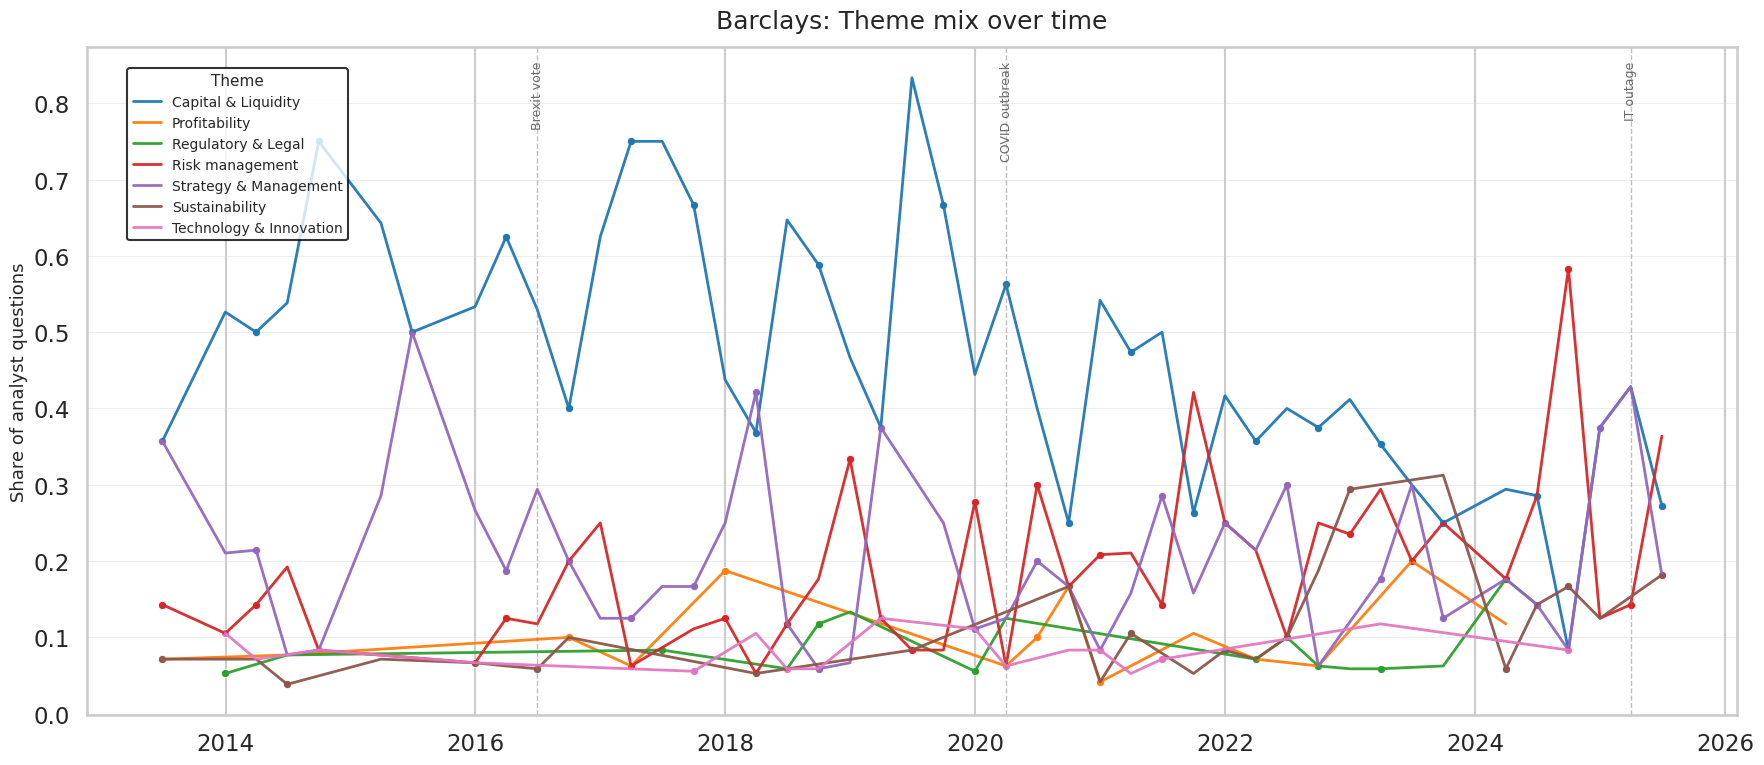

In [ ]:
plt.figure(figsize=(18,8))
sns.lineplot(
    data=tc, x="date", y="share",
    hue="theme_q", linewidth=2, alpha=0.95
)

# show markers (every 2nd point to reduce clutter)
for theme, g in tc.groupby("theme_q"):
    g2 = g.iloc[::2]
    plt.scatter(g2["date"], g2["share"], s=35, edgecolor="white", linewidth=0.6)

# axes & labels
ax = plt.gca()
ax.set_title(f"{BANK}: Theme mix over time", fontsize=18, pad=14)
ax.set_ylabel("Share of analyst questions", fontsize=13)
ax.set_xlabel("")

# event lines & labels
y_top = ax.get_ylim()[1]
for _, r in ev.iterrows():
    ax.axvline(r["date"], color="grey", linestyle="--", alpha=0.5, linewidth=1)
    ax.text(r["date"], y_top*0.98, r["label"], rotation=90,
            va="top", ha="center", fontsize=9, color="dimgray")

# grid/legend
ax.grid(True, which="major", axis="y", linewidth=0.6, alpha=0.4)

# smaller legend inside top-left with white background
plt.legend(
    title="Theme",
    loc="upper left",
    bbox_to_anchor=(0.02, 0.98),    # shift slightly inside the plot
    fontsize=10,
    title_fontsize=11,
    frameon=True,
    facecolor="white",
    edgecolor="black"
)

plt.tight_layout()
plt.show()


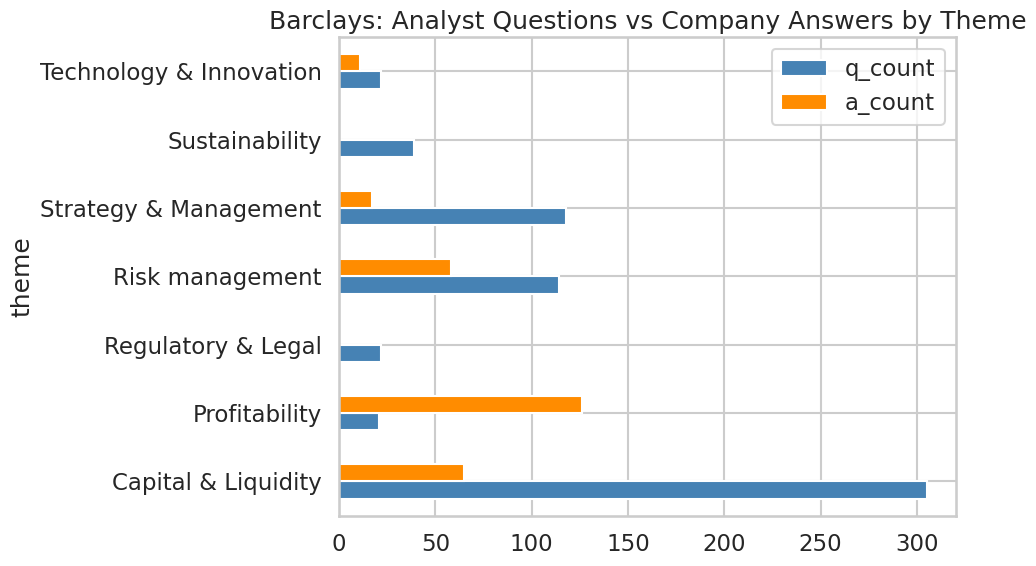

In [ ]:
# Q vs A mismatch (bar)
qa = (
    df.groupby("theme_q").size().reset_index(name="q_count")
    .merge(df.groupby("theme_a").size().reset_index(name="a_count"),
           left_on="theme_q", right_on="theme_a", how="outer")
    .fillna(0)
    .rename(columns={"theme_q":"theme"})
)

#Hide theme "Other" and "0"
qa = qa[~qa["theme"].isin(["Other",0])]
qa = qa[["theme","q_count","a_count"]].astype({"q_count":int,"a_count":int})

qa.plot(kind="barh", x="theme", figsize=(10,6),
        color=["steelblue","darkorange"])
plt.title(f"{BANK}: Analyst Questions vs Company Answers by Theme")
plt.tight_layout()
plt.show()

In [ ]:
# Cell 9: quarter-over-quarter growth
tc_growth = tc.sort_values(["theme_q","date"]).copy()
tc_growth["lag"] = tc_growth.groupby("theme_q")["share"].shift(1)
tc_growth["growth_pct"] = ((tc_growth["share"] - tc_growth["lag"]) /
                           tc_growth["lag"].replace(0, np.nan)) * 100

emerging = (tc_growth
            .dropna(subset=["growth_pct"])
            .sort_values("growth_pct", ascending=False)
            .head(10))
emerging[["year_quarter","theme_q","growth_pct"]]


,year_quarter,theme_q,growth_pct
137,2019Q1,Strategy & Management,462.500000
97,2020Q2,Risk management,380.000000
42,2024Q4,Capital & Liquidity,350.000000
157,2024Q4,Strategy & Management,350.000000
122,2015Q1,Strategy & Management,242.857143
95,2019Q4,Risk management,233.333333
57,2023Q2,Profitability,220.000000
49,2017Q4,Profitability,200.000000
102,2021Q3,Risk management,194.736842
151,2023Q1,Strategy & Management,182.352941


## CITIBANK

In [ ]:
#Importing data
uploaded = files.upload()
data_citi = pd.read_csv("citi_qna_data.csv", sep=";")

Saving citi_qna_data.csv to citi_qna_data.csv


In [ ]:
data_citi.head()

,bank,year,quarter,tag,question_speaker,analyst_firm,extracted_question,original_question_text,answer_speaker,extracted_answer,original_answer_text,answer_score,orientation,theme
0,Citi,2013,Q1,NaN,Glenn Schorr,NaN,Hi. Thanks very much. I like this disclosure. ...,Hi. Thanks very much. I like this disclosure. ...,John Gerspach,I would say that if the portfolio continues to...,I would say that if the portfolio continues to...,1.0,Mixed,Risk management
1,Citi,2013,Q1,NaN,Glenn Schorr,NaN,"Okay, cool. The comment, John, that you made e...","Okay, cool. The comment, John, that you made e...",John Gerspach,That is an ongoing area that I think everyone ...,That is an ongoing area that I think everyone ...,0.7,Mixed,Regulatory & Legal
2,Citi,2013,Q1,NaN,Glenn Schorr,NaN,So post stress test where you had super high c...,"Okay, I got that. That's very helpful. Thanks....",John Gerspach,Those are all things that are developing and m...,Those are all things that are developing and m...,0.3,Mixed,Regulatory & Legal
3,Citi,2013,Q1,NaN,Glenn Schorr,NaN,Have there been any pre-funding of it? In othe...,Have there been any pre-funding of it? In othe...,John Gerspach,"To the extent that we've had debt maturities, ...","To the extent that we've had debt maturities, ...",0.6,Past,Capital & Liquidity
4,Citi,2013,Q1,NaN,John Mcdonald,NaN,"Good morning. John, on the expenses, was wonde...","Good morning. John, on the expenses, was wonde...",John Gerspach,"No, John, we're staying with what we said at y...","No, John, we're staying with what we said at y...",1.0,Future,Profitability


In [ ]:
data_citi.shape

(2001, 14)

### Keyword extraction

In [ ]:
# Perform preprocessing of the data – change to lower case, remove stopwords using NLTK, and remove numbers.
data_citi["clean question"]=(data_citi["extracted_question"]).apply(preprocess_text)
data_citi["clean answer"]=(data_citi["extracted_answer"]).apply(preprocess_text)

#Noun extraction
question_nouns=data_citi["clean question"].apply(noun_extraction)
answer_nouns=data_citi["clean answer"].apply(noun_extraction)

data_citi["question nouns"]=question_nouns
data_citi["answer nouns"]=answer_nouns

In [ ]:
#TF-IDF

#Questions
questions_as_text = data_citi["question nouns"].apply(lambda xs: " ".join(xs))

tokens_series_q = data_citi["question nouns"].apply(lambda xs: [t for t in xs if t not in stop_words])
bigrams_q = Counter([" ".join(bg) for xs in tokens_series_q for bg in ngrams(xs, 2)])
trigrams_q = Counter([" ".join(tg) for xs in tokens_series_q for tg in ngrams(xs, 3)])
vocab_q = set([w for w,c in bigrams_q.items() if c>=10] + [w for w,c in trigrams_q.items() if c>=7])

vectorizer_q = TfidfVectorizer(vocabulary=vocab_q, ngram_range=(1,3), sublinear_tf=True)
X_q = vectorizer_q.fit_transform(questions_as_text)
terms_q = vectorizer_q.get_feature_names_out()

sums_q = X_q.sum(axis=0).tolist()[0]
avg_q  = [val / X_q.shape[0] for val in sums_q]

df_citi_q_tfidf = pd.DataFrame({"term": terms_q, "tfidf": avg_q})
df_citi_q_tfidf["type"] = "question"

#Answers
answers_as_text = data_citi["answer nouns"].apply(lambda xs: " ".join(xs))

tokens_series_a = data_citi["answer nouns"].apply(lambda xs: [t for t in xs if t not in stop_words])
bigrams_a = Counter([" ".join(bg) for xs in tokens_series_a for bg in ngrams(xs, 2)])
trigrams_a = Counter([" ".join(tg) for xs in tokens_series_a for tg in ngrams(xs, 3)])
vocab_a = set([w for w,c in bigrams_a.items() if c>=10] + [w for w,c in trigrams_a.items() if c>=7])

vectorizer_a = TfidfVectorizer(vocabulary=vocab_a, ngram_range=(1,3), sublinear_tf=True)
X_a = vectorizer_a.fit_transform(answers_as_text)
terms_a = vectorizer_a.get_feature_names_out()

sums_a = X_a.sum(axis=0).tolist()[0]
avg_a  = [val / X_a.shape[0] for val in sums_a]

df_citi_a_tfidf = pd.DataFrame({"term": terms_a, "tfidf": avg_a})
df_citi_a_tfidf["type"] = "answer"

#Combine
tfidf_citi_df = pd.concat([df_citi_q_tfidf, df_citi_a_tfidf], ignore_index=True)
tfidf_citi_df.sort_values(by="tfidf", ascending=False, inplace=True)

tfidf_citi_df.reset_index(inplace=True)
tfidf_citi_df.head(20)

tfidf_citi_df.reset_index(inplace=True)
tfidf_citi_df.drop("level_0", axis=1, inplace=True)

tfidf_citi_df.head(20)

,index,term,tfidf,type
0,66,basis point,0.030447,answer
1,2,basis point,0.030391,question
2,64,balance sheet,0.026033,answer
3,224,point view,0.020922,answer
4,253,revenue growth,0.018485,answer
5,124,efficiency ratio,0.016770,answer
6,223,point time,0.016756,answer
7,46,revenue growth,0.016095,question
8,1,balance sheet,0.015901,question
9,39,operating leverage,0.012664,question


### Topic modelling

In [ ]:
#Initial topic modelling
repr_model = MaximalMarginalRelevance(diversity=0.6)
finbert_name = "ProsusAI/finbert"
word_embedding_model = models.Transformer(finbert_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

finbert_embedder = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
#Prepare data
docs_citi_q = data_citi["question nouns"].apply(lambda xs: " ".join(xs)).tolist()
docs_citi_a = data_citi["answer nouns"].apply(lambda xs: " ".join(xs)).tolist()

In [ ]:
#Vectorizers
docs_citi_q_clean = [strip_stop_phrases(t) for t in docs_citi_q]
docs_citi_a_clean = [strip_stop_phrases(t) for t in docs_citi_a]

n_citi_q = len(docs_citi_q_clean)
n_citi_a = len(docs_citi_a_clean)

vectorizer_citi_q = make_vectorizer(n_citi_q, all_stops)
vectorizer_citi_a = make_vectorizer(n_citi_a, all_stops)

In [ ]:
#FinBERT

umap_model = umap.UMAP(
    n_neighbors=12,
    n_components=5,
    min_dist=0.1,
    metric="cosine",
    random_state=42)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=18,
    min_samples=5,
    metric='euclidean',
    cluster_selection_method='leaf',
    prediction_data=True)


#Questions
topic_model_citi_q = BERTopic(
    embedding_model=finbert_embedder,
    vectorizer_model=vectorizer_q,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=repr_model,
    top_n_words=15,
    calculate_probabilities=True,
    low_memory=True,
    verbose=False)

topics_citi_q, probs_citi_q = topic_model_citi_q.fit_transform(docs_citi_q_clean)

#Answers
topic_model_citi_a = BERTopic(
    embedding_model=finbert_embedder,
    vectorizer_model=vectorizer_citi_a,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=repr_model,
    top_n_words=15,
    calculate_probabilities=True,
    low_memory=True,
    verbose=False)

topics_citi_a, probs_citi_a = topic_model_citi_a.fit_transform(docs_citi_a_clean)

In [ ]:
#Results
topics_overview_citi_q = topic_model_citi_q.get_topic_info()
topics_overview_citi_a = topic_model_citi_a.get_topic_info()

display(topics_overview_citi_q.head(12))
display(topics_overview_citi_a.head(12))

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1188,-1_growth rate_wealth management_efficiency im...,"[growth rate, wealth management, efficiency im...",[hi discus roadmaps target target mid efficien...
1,0,78,0_efficiency improvement_growth rate_term grow...,"[efficiency improvement, growth rate, term gro...",[john target level operating leverage accelera...
2,1,76,1_tax rate_holding asset_asset sale_citi holding,"[tax rate, holding asset, asset sale, citi hol...","[tax rate guidance charge tax rate, john share..."
3,2,71,2_term growth_wealth management_talk bit_reven...,"[term growth, wealth management, talk bit, rev...",[guess guy others drawdowns income market equi...
4,3,68,3____,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[currency, year, disruption]"
5,4,60,4_efficiency ratio_target basis point_investme...,"[efficiency ratio, target basis point, investm...",[clarification slide job jenn tom mark curve i...
6,5,52,5_investment banking_bit color_capital market_,"[investment banking, bit color, capital market...",[pipeline color investment banking pipeline ha...
7,6,43,6_expense revenue_revenue expense_expense rati...,"[expense revenue, revenue expense, expense rat...",[expense curve bend curve bend right expense e...
8,7,41,7_rate hike_point basis point_target basis poi...,"[rate hike, point basis point, target basis po...",[question security path target basis point div...
9,8,40,8_efficiency target_investment spend_consumer ...,"[efficiency target, investment spend, consumer...",[couple question investment spend branch ceter...


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1046,-1_return_loan_balance sheet_tax,"[return, loan, balance sheet, tax, earnings, m...",[id everyone target vision strategy progress m...
1,0,110,0_loan_customer_service_play,"[loan, customer, service, play, result, month,...",[reserve nothing mike use reserve mortgage don...
2,1,93,1_strategy_customer_service_world,"[strategy, customer, service, world, return, e...",[pas mark look advice vision preeminent bankin...
3,2,72,2____,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , ]"
4,3,71,3_dollar_currency_month_security,"[dollar, currency, month, security, yield, out...",[yeah id point range cut youve reason ire basi...
5,4,70,4_mexico_return_service_result,"[mexico, return, service, result, asia, ratio,...",[look look look essence movie revenue expense ...
6,5,59,5_dollar_reference_future_help,"[dollar, reference, future, help, page, asia, ...","[couple day let, couple dollar something, mix ..."
7,6,49,6_week_expense_nothing_pace,"[week, expense, nothing, pace, plan, deposit, ...","[expense, expense, week]"
8,7,45,7_mean_information_start_need,"[mean, information, start, need, citi, cetera,...",[right dont rule let chance look rule tell kin...
9,8,42,8_feel_asia_reason_week,"[feel, asia, reason, week, help, information, ...",[credit feel admit dont rate bit anything chan...


In [ ]:
#Top words.
top_topics_citi_q = topics_overview_citi_q[topics_overview_citi_q.Topic != -1]
words_top10_citi_q=list(top_topics_citi_q["Representation"].head(10))
print("Top words (Questions data):")
print(words_top10_citi_q)

top_topics_citi_a = topics_overview_a[topics_overview_citi_a.Topic != -1&0]
words_top10_citi_a=list(top_topics_citi_a["Representation"].head(10))
print("\nTop words (Answers data):")
print(words_top10_citi_a)

Top words (Questions data):
[['efficiency improvement', 'growth rate', 'term growth', 'target basis point', 'investment spend', 'market share', 'bit color', 'hi john', 'revenue expense', '', ''], ['tax rate', 'holding asset', 'asset sale', 'citi holding', 'credit card', 'interest income', 'rate environment', 'revenue expense', 'run rate', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['term growth', 'wealth management', 'talk bit', 'revenue environment', 'market share', 'expense revenue', 'loan growth', 'holding asset', 'basis point', '', '', '', '', '', '', '', ''], ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['efficiency ratio', 'target basis point', 'investment spend', 'hi john', 'revenue expense', 'asset sale', 'guess im', 'citi holding', 'investor day', '', '', '', '', '', '', '', '', ''], ['investment banking', 'bit color', 'capital market', '', '', '', '', '', '', '', '', '', '',

In [ ]:
#interactive visualisation of the topics.
topic_model_citi_q.visualize_topics()

In [ ]:
topic_model_citi_a.visualize_topics()

In [ ]:
#Barchart of the topics
topic_model_citi_q.visualize_barchart()

In [ ]:
topic_model_citi_a.visualize_barchart()

In [ ]:
#Heatmap
topic_model_citi_q.visualize_heatmap()

In [ ]:
topic_model_citi_a.visualize_heatmap()

### Mapping topics to curated themes

In [ ]:
# Get per-document topics from BERTopic (safer than relying on a saved array)
docinfo_citi_q = topic_model_citi_q.get_document_info(docs_citi_q_clean).rename(columns={"Topic":"topic_q"})
docinfo_citi_a = topic_model_citi_a.get_document_info(docs_citi_a_clean).rename(columns={"Topic":"topic_a"})

# Align by index to your original data
data_citi = data_citi.reset_index(drop=True)
assert len(data_citi) == len(docinfo_citi_q) == len(docinfo_citi_a), "Lengths mismatch—check filtering steps."

data_citi["topic_q"] = docinfo_citi_q["topic_q"].values
data_citi["topic_a"] = docinfo_citi_a["topic_a"].values


In [ ]:
zero_shot = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
THEMES = [theme for theme in data_citi["theme"].unique() if theme != "Other"]

themes_citi_q = {t: theme_for_topic(topic_model_citi_q, t) for t in topics_overview_citi_q.Topic if t != -1}
themes_citi_a = {t: theme_for_topic(topic_model_citi_a, t) for t in topics_overview_citi_a.Topic if t != -1}

data_citi["theme_q"] = data_citi["topic_q"].map(themes_citi_q).fillna("Other")
data_citi["theme_a"] = data_citi["topic_a"].map(themes_citi_a).fillna("Other")

Device set to use cpu


### Exploratory visualization

In [ ]:
sns.set_context("talk")
sns.set_style("whitegrid")
BANK = "Citi"

df_citi = data_citi.copy()
df_citi = df_citi[df_citi["bank"] == BANK].copy()

# optional: drop Outliers theme
df_citi = df_citi[df_citi["theme_q"] != "Other"].copy()

# ensure year_quarter exists
df_citi["year_quarter"] = df_citi["year"].astype(str) + df_citi["quarter"].astype(str)


In [ ]:
theme_counts_citi = (
    df_citi.groupby(["year_quarter", "theme_q"])
      .size()
      .reset_index(name="count")
      .sort_values(["theme_q","year_quarter"])
)

theme_counts_citi["total"] = theme_counts_citi.groupby("year_quarter")["count"].transform("sum")
theme_counts_citi["share"] = theme_counts_citi["count"] / theme_counts_citi["total"]
theme_counts_citi.head()


,year_quarter,theme_q,count,total,share
0,2013Q1,Capital & Liquidity,2,31,0.064516
5,2013Q2,Capital & Liquidity,2,25,0.080000
10,2013Q3,Capital & Liquidity,1,38,0.026316
15,2013Q4,Capital & Liquidity,1,35,0.028571
20,2014Q1,Capital & Liquidity,1,24,0.041667


In [ ]:
#convert Year-Quarter -> Timestamp (quarter end)

tc_citi = theme_counts_citi.copy()
tc_citi["date"] = tc_citi["year_quarter"].apply(yq_to_date)
tc_citi = tc_citi.dropna(subset=["date"])   # remove rows with bad quarter strings
tc_citi = tc_citi.sort_values(["theme_q","date"]).reset_index(drop=True)
tc_citi.head()


,year_quarter,theme_q,count,total,share,date
0,2013Q1,Capital & Liquidity,2,31,0.064516,2013-03-31
1,2013Q2,Capital & Liquidity,2,25,0.080000,2013-06-30
2,2013Q3,Capital & Liquidity,1,38,0.026316,2013-09-30
3,2013Q4,Capital & Liquidity,1,35,0.028571,2013-12-31
4,2014Q1,Capital & Liquidity,1,24,0.041667,2014-03-31


In [ ]:
# events to annotate
events = {
    "2016Q2": "Brexit vote",
    "2020Q1": "COVID outbreak",
}
ev = pd.DataFrame({
    "date": [yq_to_date(k) for k in events.keys()],
    "label": list(events.values())
})


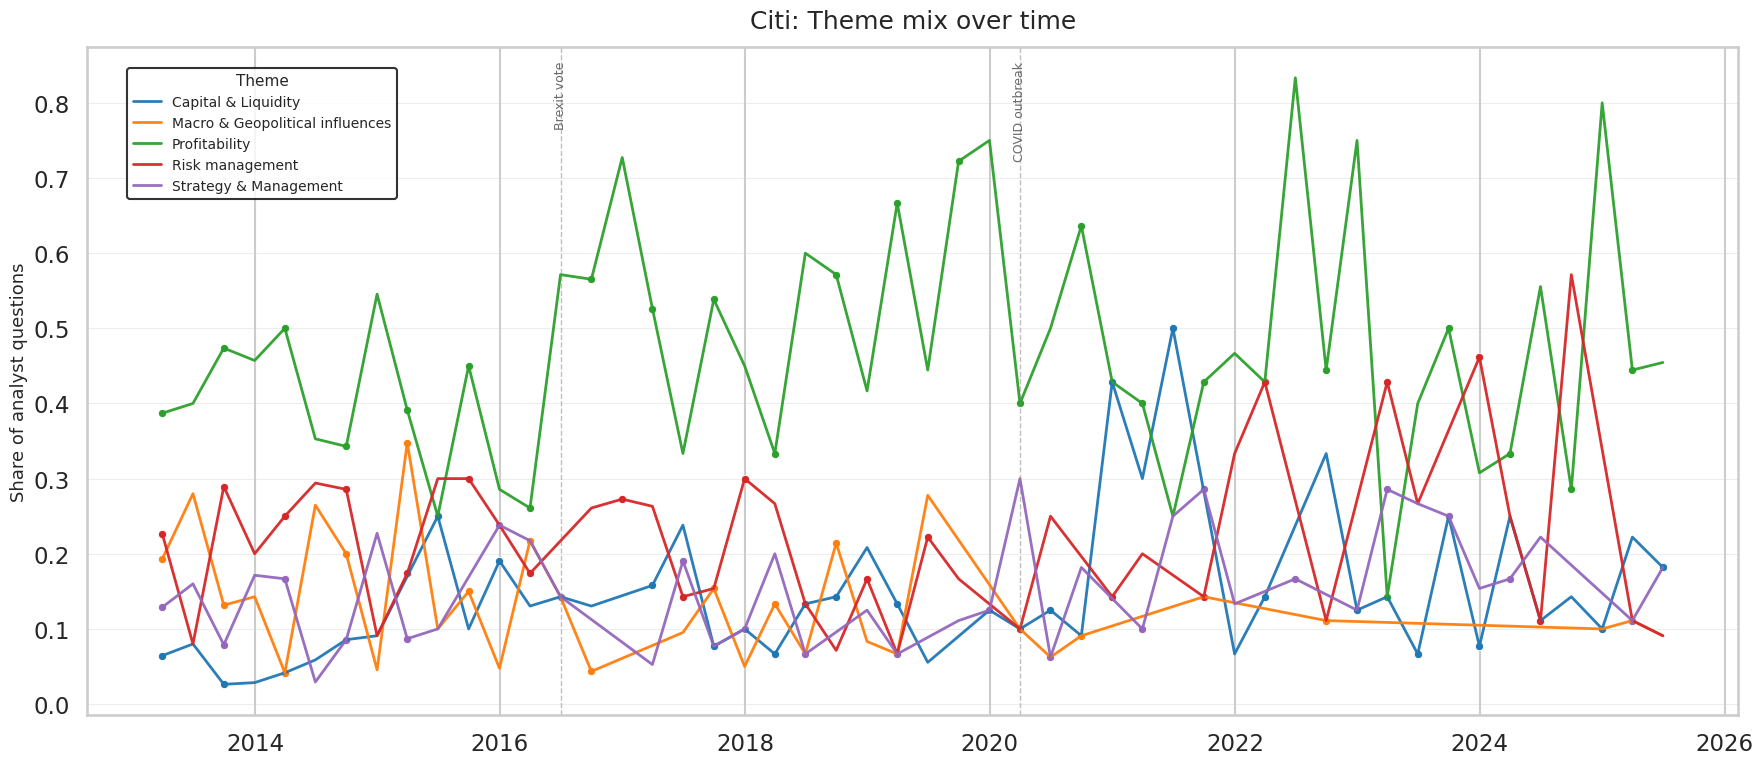

In [ ]:
plt.figure(figsize=(18,8))
sns.lineplot(
    data=tc_citi, x="date", y="share",
    hue="theme_q", linewidth=2, alpha=0.95
)

# show markers (every 2nd point to reduce clutter)
for theme, g in tc_citi.groupby("theme_q"):
    g2 = g.iloc[::2]
    plt.scatter(g2["date"], g2["share"], s=35, edgecolor="white", linewidth=0.6)

# axes & labels
ax = plt.gca()
ax.set_title(f"{BANK}: Theme mix over time", fontsize=18, pad=14)
ax.set_ylabel("Share of analyst questions", fontsize=13)
ax.set_xlabel("")

# event lines & labels
y_top = ax.get_ylim()[1]
for _, r in ev.iterrows():
    ax.axvline(r["date"], color="grey", linestyle="--", alpha=0.5, linewidth=1)
    ax.text(r["date"], y_top*0.98, r["label"], rotation=90,
            va="top", ha="center", fontsize=9, color="dimgray")

# grid/legend
ax.grid(True, which="major", axis="y", linewidth=0.6, alpha=0.4)

# smaller legend inside top-left with white background
plt.legend(
    title="Theme",
    loc="upper left",
    bbox_to_anchor=(0.02, 0.98),    # shift slightly inside the plot
    fontsize=10,
    title_fontsize=11,
    frameon=True,
    facecolor="white",
    edgecolor="black"
)

plt.tight_layout()
plt.show()


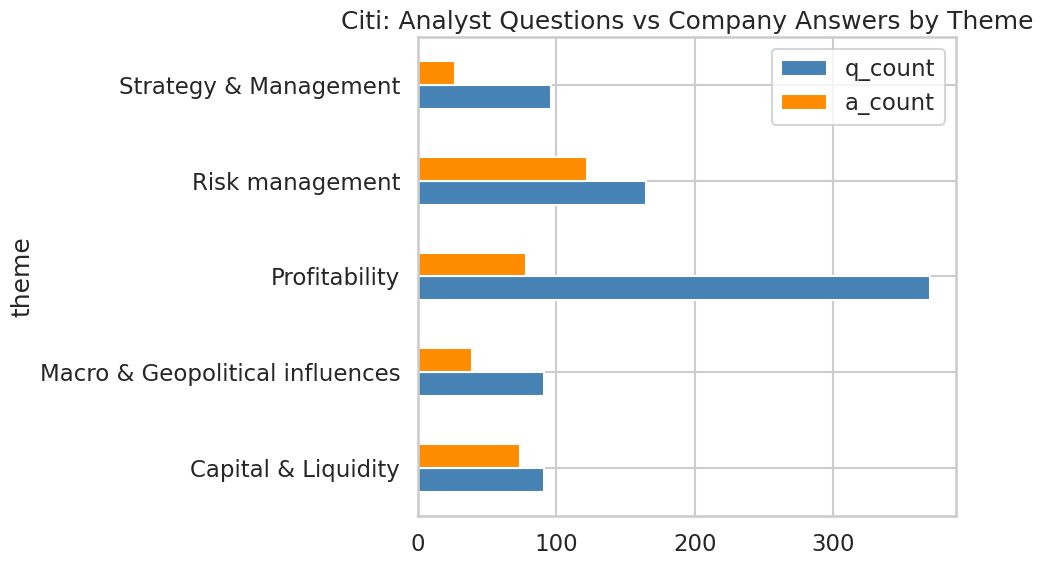

In [ ]:
# Q vs A mismatch (bar)
qa_citi = (
    df_citi.groupby("theme_q").size().reset_index(name="q_count")
    .merge(df_citi.groupby("theme_a").size().reset_index(name="a_count"),
           left_on="theme_q", right_on="theme_a", how="outer")
    .fillna(0)
    .rename(columns={"theme_q":"theme"})
)

#Hide theme "Other" and "0"
qa_citi = qa_citi[~qa_citi["theme"].isin(["Other",0])]
qa_citi = qa_citi[["theme","q_count","a_count"]].astype({"q_count":int,"a_count":int})

qa_citi.plot(kind="barh", x="theme", figsize=(10,6),
        color=["steelblue","darkorange"])
plt.title(f"{BANK}: Analyst Questions vs Company Answers by Theme")
plt.tight_layout()
plt.show()

In [ ]:
# Cell 9: quarter-over-quarter growth
tc_growth_citi = tc_citi.sort_values(["theme_q","date"]).copy()
tc_growth_citi["lag"] = tc_growth_citi.groupby("theme_q")["share"].shift(1)
tc_growth_citi["growth_pct"] = ((tc_growth_citi["share"] - tc_growth_citi["lag"]) /
                           tc_growth_citi["lag"].replace(0, np.nan)) * 100

emerging_citi = (tc_growth_citi
            .dropna(subset=["growth_pct"])
            .sort_values("growth_pct", ascending=False)
            .head(10))
emerging_citi[["year_quarter","theme_q","growth_pct"]]


,year_quarter,theme_q,growth_pct
53,2015Q1,Macro & Geopolitical influences,665.217391
50,2014Q2,Macro & Geopolitical influences,535.294118
166,2024Q3,Risk management,414.285714
28,2020Q4,Capital & Liquidity,371.428571
57,2016Q1,Macro & Geopolitical influences,356.521739
68,2019Q2,Macro & Geopolitical influences,316.666667
161,2023Q1,Risk management,285.714286
37,2023Q3,Capital & Liquidity,275.000000
183,2017Q2,Strategy & Management,261.904762
129,2013Q3,Risk management,261.842105


# STAGE 4: Sentiment analysis

At this stage we characterize the **emotional tone** of questions and answers and derive a coarse **sentiment** tag (positive/negative/neutral/uncertain).

We use a multi-class emotion model (`bhadresh-savani/bert-base-uncased-emotion`) to obtain a distribution over emotions for each text.  
For each row we store:
- the top emotion label;  
- its score;  
- the full probability distribution (JSON).  

A rule-based mapping converts high-confidence emotions into sentiment:
- Positive: {joy, love, surprise}  
- Negative: {anger, sadness, fear, disgust}  
- Low-confidence (< threshold) → `uncertain`

### Notes & Limitations

Emotion models are trained on general text; while they perform reasonably on finance transcripts, nuance (e.g., measured corporate tone) may be under-detected.  
Scores are best interpreted **comparatively** across time/themes rather than absolutely.


## BARCLAYS

In [ ]:
#Importing packages
emotion_classifier = pipeline("text-classification", model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=True, max_length=256)

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
#Function to classify a series of texts in batches by emotion, returning for each text the most likely emotion and its score
def _top_label_and_score(all_scores_one_text):
    best = max(all_scores_one_text, key=lambda x: x["score"])
    return best["label"], float(best["score"])

def classify_series_emotion(series, batch_size=32):
    texts = series.fillna("").astype(str).tolist()
    labels, scores, dists = [], [], []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        outputs = emotion_classifier(batch, truncation=True)
        for out in outputs:
            lab, sc = _top_label_and_score(out)
            labels.append(lab)
            scores.append(sc)
            dist = {d["label"]: float(d["score"]) for d in out}
            dists.append(json.dumps(dist))
    return labels, scores, dists

In [ ]:
#Apply to data
q_labels, q_scores, q_dists = classify_series_emotion(data["extracted_question"])
data["question_emotion"] = q_labels
data["question_emotion_score"] = q_scores
data["question_emotion_dist"] = q_dists

a_labels, a_scores, a_dists = classify_series_emotion(data["extracted_answer"])
data["answer_emotion"] = a_labels
data["answer_emotion_score"] = a_scores
data["answer_emotion_dist"] = a_dists

In [ ]:
#Function to map positivity or negativity
def sentiment_from_emotion(label, score, threshold=0.6):
    pos = {"joy", "love", "surprise"}
    neg = {"anger", "sadness", "fear", "disgust"}
    if score < threshold:
        return "uncertain"
    elif label in pos:
        return "positive"
    elif label in neg:
        return "negative"
    return "neutral"

data["question_sentiment"] = [sentiment_from_emotion(l, s) for l, s in zip(q_labels, q_scores)]
data["answer_sentiment"] = [sentiment_from_emotion(l, s) for l, s in zip(a_labels, a_scores)]

In [ ]:
data.head(10)

,bank,year,quarter,tag,question_speaker,analyst_firm,extracted_question,original_question_text,answer_speaker,extracted_answer,...,theme_q,theme_a,question_emotion,question_emotion_score,question_emotion_dist,answer_emotion,answer_emotion_score,answer_emotion_dist,question_sentiment,answer_sentiment
0,Barclays,2013,Q2,H1,Chris Manners,Morgan Stanley,My first question is about the movements in th...,My first question is about the movements in th...,"Antony Jenkins, Group Chief Executive | Chris ...","Let me do that, and it’ll take a few minutes, ...",...,Other,Other,joy,0.675825,"{""sadness"": 0.01647213287651539, ""joy"": 0.6758...",joy,0.936625,"{""sadness"": 0.03600052371621132, ""joy"": 0.9366...",positive,positive
1,Barclays,2013,Q2,H1,Chris Manners,Morgan Stanley,The second one was on the cost of deleveraging...,My first question is about the movements in th...,"Antony Jenkins, Group Chief Executive | Chris ...","Thanks, Chris. Let me take the second part of ...",...,Risk management,Other,joy,0.912255,"{""sadness"": 0.013183338567614555, ""joy"": 0.912...",joy,0.840390,"{""sadness"": 0.01508477982133627, ""joy"": 0.8403...",positive,positive
2,Barclays,2013,Q2,H1,Raul Sinha,JP Morgan,"Good morning, Antony; good morning, Chris. The...","Good morning, Antony; good morning, Chris. The...",Antony Jenkins,"Well, can I just correct you mildly there? We ...",...,Profitability,Profitability,anger,0.977262,"{""sadness"": 0.008228677324950695, ""joy"": 0.008...",anger,0.946450,"{""sadness"": 0.004088171757757664, ""joy"": 0.042...",negative,negative
3,Barclays,2013,Q2,H1,Raul Sinha,JP Morgan,The second one I had was obviously you’ve rais...,The second one I had was obviously you’ve rais...,Antony Jenkins,"So as you know on s165, there is no published ...",...,Strategy & Management,Capital & Liquidity,anger,0.720676,"{""sadness"": 0.0076008629985153675, ""joy"": 0.25...",joy,0.987106,"{""sadness"": 0.005260858219116926, ""joy"": 0.987...",negative,positive
4,Barclays,2013,Q2,H1,Raul Sinha,JP Morgan,"Sure. If I can just follow up on that, Antony?...","Sure. If I can just follow up on that, Antony?...",Antony Jenkins,Yes. There’s no difference in the strategy her...,...,Strategy & Management,Other,joy,0.984363,"{""sadness"": 0.002167738974094391, ""joy"": 0.984...",joy,0.967344,"{""sadness"": 0.011772324331104755, ""joy"": 0.967...",positive,positive
5,Barclays,2013,Q2,H1,JP Crutchley,UBS,So I guess the first question is now if you we...,"Morning, all: JP here. I’d like to maybe explo...",Antony Jenkins,NOT ANSWERED,...,Other,Macro & Geopolitical influences,joy,0.919743,"{""sadness"": 0.024379262700676918, ""joy"": 0.919...",anger,0.926055,"{""sadness"": 0.013867709785699844, ""joy"": 0.031...",positive,negative
6,Barclays,2013,Q2,H1,JP Crutchley,UBS,The second question then comes back to almost ...,"Morning, all: JP here. I’d like to maybe explo...",Antony Jenkins,NOT ANSWERED,...,Other,Macro & Geopolitical influences,joy,0.879176,"{""sadness"": 0.002777049085125327, ""joy"": 0.879...",anger,0.926055,"{""sadness"": 0.013867709785699844, ""joy"": 0.031...",positive,negative
7,Barclays,2013,Q2,H1,Fiona Swaffield,RBC,Hi. Good morning. I just wondered if we could ...,Hi. Good morning. I just wondered if we could ...,Antony Jenkins,I don’t think it does represent the new base f...,...,Other,Risk management,joy,0.969987,"{""sadness"": 0.0025075296871364117, ""joy"": 0.96...",sadness,0.391543,"{""sadness"": 0.39154326915740967, ""joy"": 0.3518...",positive,uncertain
8,Barclays,2013,Q2,H1,Chintan Joshi,Nomura,If I start off with a follow-up on Raul's ques...,"Good morning, gents. A few questions, please. ...",Antony Jenkins,"In terms of your question on capital, remember...",...,Other,Other,joy,0.501791,"{""sadness"": 0.11022092401981354, ""joy"": 0.5017...",joy,0.991687,"{""sadness"": 0.003476745216175914, ""joy"": 0.991...",uncertain,positive
9,Barclays,2013,Q2,H1,Chintan Joshi,Nomura,The other question was if I assume that you're...,"Good

In [ ]:
#SAVE FINAL DATAFRAME (STREAMLIT)
out_csv = "barclays_FINAL.csv"
if not data.empty:
    data.to_csv(out_csv, index=False)
    print(f"Saved → {out_csv}")

Saved → barclays_FINAL.csv


## CITIBANK

In [ ]:
#Importing packages
emotion_classifier = pipeline("text-classification", model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=True, max_length=256)

Device set to use cpu


In [ ]:
#Classify emotion
q_labels_citi, q_scores_citi, q_dists_citi = classify_series_emotion(data_citi["extracted_question"])
data_citi["question_emotion"] = q_labels_citi
data_citi["question_emotion_score"] = q_scores_citi
data_citi["question_emotion_dist"] = q_dists_citi

a_labels_citi, a_scores_citi, a_dists_citi = classify_series_emotion(data_citi["extracted_answer"])
data_citi["answer_emotion"] = a_labels_citi
data_citi["answer_emotion_score"] = a_scores_citi
data_citi["answer_emotion_dist"] = a_dists_citi

#Map positivity or negativity
data_citi["question_sentiment"] = [sentiment_from_emotion(l, s) for l, s in zip(q_labels_citi, q_scores_citi)]
data_citi["answer_sentiment"] = [sentiment_from_emotion(l, s) for l, s in zip(a_labels_citi, a_scores_citi)]

In [ ]:
data.head(10)

,bank,year,quarter,tag,question_speaker,analyst_firm,extracted_question,original_question_text,answer_speaker,extracted_answer,...,theme_q,theme_a,question_emotion,question_emotion_score,question_emotion_dist,answer_emotion,answer_emotion_score,answer_emotion_dist,question_sentiment,answer_sentiment
0,Barclays,2013,Q2,H1,Chris Manners,Morgan Stanley,My first question is about the movements in th...,My first question is about the movements in th...,"Antony Jenkins, Group Chief Executive | Chris ...","Let me do that, and it’ll take a few minutes, ...",...,Other,Other,joy,0.675825,"{""sadness"": 0.01647213287651539, ""joy"": 0.6758...",joy,0.936625,"{""sadness"": 0.03600052371621132, ""joy"": 0.9366...",positive,positive
1,Barclays,2013,Q2,H1,Chris Manners,Morgan Stanley,The second one was on the cost of deleveraging...,My first question is about the movements in th...,"Antony Jenkins, Group Chief Executive | Chris ...","Thanks, Chris. Let me take the second part of ...",...,Risk management,Other,joy,0.912255,"{""sadness"": 0.013183338567614555, ""joy"": 0.912...",joy,0.840390,"{""sadness"": 0.01508477982133627, ""joy"": 0.8403...",positive,positive
2,Barclays,2013,Q2,H1,Raul Sinha,JP Morgan,"Good morning, Antony; good morning, Chris. The...","Good morning, Antony; good morning, Chris. The...",Antony Jenkins,"Well, can I just correct you mildly there? We ...",...,Profitability,Profitability,anger,0.977262,"{""sadness"": 0.008228677324950695, ""joy"": 0.008...",anger,0.946450,"{""sadness"": 0.004088171757757664, ""joy"": 0.042...",negative,negative
3,Barclays,2013,Q2,H1,Raul Sinha,JP Morgan,The second one I had was obviously you’ve rais...,The second one I had was obviously you’ve rais...,Antony Jenkins,"So as you know on s165, there is no published ...",...,Strategy & Management,Capital & Liquidity,anger,0.720676,"{""sadness"": 0.0076008629985153675, ""joy"": 0.25...",joy,0.987106,"{""sadness"": 0.005260858219116926, ""joy"": 0.987...",negative,positive
4,Barclays,2013,Q2,H1,Raul Sinha,JP Morgan,"Sure. If I can just follow up on that, Antony?...","Sure. If I can just follow up on that, Antony?...",Antony Jenkins,Yes. There’s no difference in the strategy her...,...,Strategy & Management,Other,joy,0.984363,"{""sadness"": 0.002167738974094391, ""joy"": 0.984...",joy,0.967344,"{""sadness"": 0.011772324331104755, ""joy"": 0.967...",positive,positive
5,Barclays,2013,Q2,H1,JP Crutchley,UBS,So I guess the first question is now if you we...,"Morning, all: JP here. I’d like to maybe explo...",Antony Jenkins,NOT ANSWERED,...,Other,Macro & Geopolitical influences,joy,0.919743,"{""sadness"": 0.024379262700676918, ""joy"": 0.919...",anger,0.926055,"{""sadness"": 0.013867709785699844, ""joy"": 0.031...",positive,negative
6,Barclays,2013,Q2,H1,JP Crutchley,UBS,The second question then comes back to almost ...,"Morning, all: JP here. I’d like to maybe explo...",Antony Jenkins,NOT ANSWERED,...,Other,Macro & Geopolitical influences,joy,0.879176,"{""sadness"": 0.002777049085125327, ""joy"": 0.879...",anger,0.926055,"{""sadness"": 0.013867709785699844, ""joy"": 0.031...",positive,negative
7,Barclays,2013,Q2,H1,Fiona Swaffield,RBC,Hi. Good morning. I just wondered if we could ...,Hi. Good morning. I just wondered if we could ...,Antony Jenkins,I don’t think it does represent the new base f...,...,Other,Risk management,joy,0.969987,"{""sadness"": 0.0025075296871364117, ""joy"": 0.96...",sadness,0.391543,"{""sadness"": 0.39154326915740967, ""joy"": 0.3518...",positive,uncertain
8,Barclays,2013,Q2,H1,Chintan Joshi,Nomura,If I start off with a follow-up on Raul's ques...,"Good morning, gents. A few questions, please. ...",Antony Jenkins,"In terms of your question on capital, remember...",...,Other,Other,joy,0.501791,"{""sadness"": 0.11022092401981354, ""joy"": 0.5017...",joy,0.991687,"{""sadness"": 0.003476745216175914, ""joy"": 0.991...",uncertain,positive
9,Barclays,2013,Q2,H1,Chintan Joshi,Nomura,The other question was if I assume that you're...,"Good

In [ ]:
#SAVE FINAL DATAFRAME (STREAMLIT)
out_citi_csv = "citi_FINAL.csv"
if not data_citi.empty:
    data_citi.to_csv(out_citi_csv, index=False)
    print(f"Saved → {out_citi_csv}")

Saved → citi_FINAL.csv
